### Remark
Train 50 with Olmo's DS. Use real SM mixture (QCD, W, tt, Z)

In [1]:
import h5py
from glob import glob
import sys, scipy
from scipy.stats import chi2
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.utils import shuffle

In [24]:
import gpustat
gpustat.print_gpustat()
import os
os.environ['CUDA_VISIBLE_DEVICES']='2,3,4'
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

imperium-sm.hep.caltech.edu  Wed Jul 31 05:11:57 2019  418.67
[0] GeForce GTX 1080 | 39'C,   0 % |   666 /  8119 MB | 3038(655M)
[1] GeForce GTX 1080 | 25'C,   0 % |  8056 /  8119 MB | qnguyen(8045M)
[2] GeForce GTX 1080 | 27'C,   0 % |     1 /  8119 MB |
[3] GeForce GTX 1080 | 23'C,   0 % |     1 /  8119 MB |
[4] GeForce GTX 1080 | 26'C,   0 % |     1 /  8119 MB |
[5] GeForce GTX 1080 | 25'C,   0 % |     1 /  8119 MB |
[6] GeForce GTX 1080 | 25'C,   0 % |     1 /  8119 MB |
[7] GeForce GTX 1080 | 27'C,   0 % |     1 /  8119 MB |


In [25]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.utils.data.distributed
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn import DataParallel

# Setup

In [4]:
LATENT_DIM = 20
HIDDEN_SIZE = 30
INPUT_LENGTH = 50
BETA = 1 # VAE 
INPUT_SIZE = 11 # pt eta phi + 8 pid
model_file = 'Nonstop_Olmo1hot_AdvancedLoss_HIDDEN{}_DIM{}_{}pars_RegularizeAttention_AnnealingKL_IAF.torch'.format(HIDDEN_SIZE, LATENT_DIM, INPUT_LENGTH)
#model_file='Seq2seq_OlmoDS1hot_SinPhi_AdvancedLoss_DIM20_50pars_RegularizeAttention_AnnealingKL_IAF.torch'
retrain=True
restandardize=False

In [36]:
training_params = {'batch_size': 1000,
                   'shuffle': True,
                   'num_workers': 0
                  }

max_epochs = 500

eval_params = {'batch_size': 5000,
               'num_workers': 0
              }
BATCH_SIZE = training_params['batch_size']

# Data Visuaization

In [37]:
sys.path.append('/nfshome/qnguyen/Seq2seqAnomalyDetection/lib')
from progressBar import ProgressBar
#from utils import EarlyStopping, createROC_curve

In [38]:
print(sys.path)

['/lib', '/nfshome/qnguyen/Seq2seqAnomalyDetection', '/usr/lib64/python36.zip', '/usr/lib64/python3.6', '/usr/lib64/python3.6/lib-dynload', '', '/usr/local/lib64/python3.6/site-packages', '/usr/local/lib/python3.6/site-packages', '/usr/lib64/python3.6/site-packages', '/usr/lib/python3.6/site-packages', '/usr/local/lib/python3.6/site-packages/IPython/extensions', '/nfshome/qnguyen/.ipython', '/nfshome/qnguyen/Seq2seqAnomalyDetection/lib', '/nfshome/qnguyen/Seq2seqAnomalyDetection/lib']


In [39]:
from dataLoaders import ParticleDataset

In [40]:
dataset = ParticleDataset(template='/bigdata/shared/ocerri/ParticleBasedAnomalyDetection/data/20190719_50part_PtOrder_v3/{}.npy', 
                          N_part=INPUT_LENGTH, N_features=INPUT_SIZE)

In [41]:
dataset.loadTrainSM(N_train_max=1e6)
dataset.charge(dataset.SMMix_train)

Fetching Wlnu
Fetching qcd
Fetching Zll
Fetching ttbar
Expected 1.00M train
Expected 1.00M val

Loading Wlnu
Loading qcd
Loading Zll
Loading ttbar
+--------+----------+-------+------+
| Sample | Evts tot | Train | Val  |
+--------+----------+-------+------+
|  Wlnu  |  3262k   |  592k | 592k |
|  qcd   |  1166k   |  338k | 338k |
|  Zll   |  1777k   |  67k  | 67k  |
| ttbar  |  2056k   |   3k  |  3k  |
+--------+----------+-------+------+
Tot training 1.00 M
Tot val 1.00 M


In [42]:
dataset.loadValidationSamples('SM+BSM')

Loading Ato4l (47.7k)
Loading leptoquark (273.6k)
Loading hToTauTau (353.6k)
Loading hChToTauNu (339.0k)
Loading Wlnu (2670.2k)
Loading qcd (828.2k)
Loading Zll (1710.4k)
Loading ttbar (2053.4k)
SM Mix limiting stat. sample: qcd (0.83M)
SM validation weights
[('Wlnu', 0.5432464655139648445), ('qcd', 1.0), ('Zll', 0.095983666442514178176), ('ttbar', 0.0035799148395852609885)]


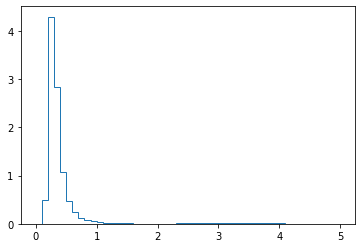

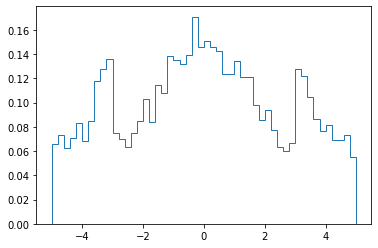

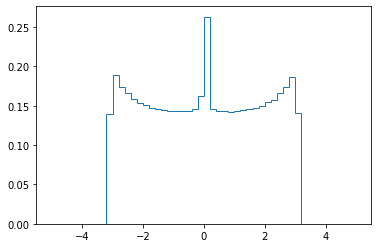

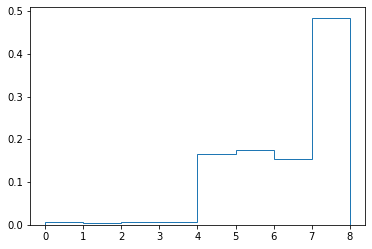

In [43]:
plt.figure()
#plt.hist(dataset.SMMix_train[:,:,0].flatten(),bins=50, histtype='step', range=(0,5), density=True)
plt.hist(dataset.SMMix_val[:,:,0].flatten(),bins=50, histtype='step', range=(0,5), density=True)
plt.show()

plt.figure()
#plt.hist(dataset.SMMix_train[:,:,1].flatten(),bins=50, histtype='step', range=(-5,5), density=True)
plt.hist(dataset.SMMix_val[:,:,1].flatten(),bins=50, histtype='step', range=(-5,5), density=True)
plt.show()

plt.figure()
#plt.hist(dataset.SMMix_train[:,:,2].flatten(),bins=50, histtype='step', range=(-5,5), density=True)
plt.hist(dataset.SMMix_val[:,:,2].flatten(),bins=50, histtype='step', range=(-5,5), density=True)
plt.show()

plt.figure()
#plt.hist(np.argmax(dataset.SMMix_train[:,:,3:], axis=2).flatten(),bins=8, histtype='step', range=(0,8), density=True)
plt.hist(np.argmax(dataset.SMMix_val[:,:,3:], axis=2).flatten(),bins=8, histtype='step', range=(0,8), density=True)
plt.show()



In [44]:
pt_std = np.std(dataset.SMMix_val[:,:,0].flatten())
eta_std = np.std(dataset.SMMix_val[:,:,1].flatten())
phi_std = 1 #np.std(dataset.SMMix_val[:,:,2].flatten())
print(phi_std)

1



# Loading Data For Training

In [45]:



# def pad_packed_sequence(sequence, batch_first=False, padding_value=0.0, total_length=None):
#     var_data, batch_sizes = sequence
#     #print("batch sizes = {}".format(batch_sizes))
#     max_batch_size = int(batch_sizes[0])
#     max_seq_length = len(batch_sizes)
#     if total_length is not None:
#         if total_length < max_seq_length:
#             raise ValueError("Expected total_length to be at least the length "
#                              "of the longest sequence in input, but got "
#                              "total_length={} and max sequence length being {}"
#                              .format(total_length, max_seq_length))
#         max_seq_length = total_length
    
    
#     output = var_data.data.new(max_seq_length, max_batch_size, *var_data.size()[1:]).fill_(padding_value)
#     output = Variable(output)

#     lengths = []
#     data_offset = 0
#     prev_batch_size = int(batch_sizes[0])
#     prev_i = 0
#     for i, batch_size in enumerate(batch_sizes + [0]):
#         if batch_size != prev_batch_size:
#             l = prev_batch_size * (i - prev_i)
#             tmp = var_data[data_offset:data_offset + l]
#             output[prev_i:i, :prev_batch_size] = tmp.view(i - prev_i, prev_batch_size, *tmp.size()[1:])
#             data_offset += l
#             prev_i = i
#         dec = prev_batch_size - batch_size
#         if dec > 0:
#             lengths.extend((i,) * dec)
#         prev_batch_size = batch_size

#     lengths.reverse()

#     if batch_first:
#         output = output.transpose(0, 1)
#     return output, lengths

def flip_h(x):
    x_size = x.data.size()
    inds = list(range(x_size[1]))[::-1]
    inds = torch.LongTensor(inds)
    if x.is_cuda:
        inds = inds.cuda()
    return x[:,inds]

class TrilLinear(nn.Linear):
    def __init__(self, features, bias=True):
        super(TrilLinear, self).__init__(features, features, bias)
        
    def forward(self, input):
        weight_tril = self.weight.tril(-1)
        return F.linear(input, weight_tril, self.bias)
    
class AutoregressiveLinear(nn.Module):
    def __init__(self, autoregressive_features, context_features):
        super(AutoregressiveLinear, self).__init__()
        
        self.lin_tril = TrilLinear(autoregressive_features)
        self.lin_ctx = nn.Linear(context_features, autoregressive_features)
        
    def forward(self, input, context):
        x0 = self.lin_tril(input) 
        x1 = self.lin_ctx(context) 
        x = x0 + x1
        
#         print("lin_tril:")
#         print(x0)
#         print("lin_context:")
#         print(x1)
        return x
        
    
class IAFLinear(nn.Module):
    def __init__(self, autoregressive_features, context_features, flip=True):
        super(IAFLinear, self).__init__()
        
        self.lin_m = AutoregressiveLinear(autoregressive_features, context_features)
        self.lin_s = AutoregressiveLinear(autoregressive_features, context_features)
        self.hardtanh = nn.Hardtanh(1,3)
        self.flip = flip
        
    def forward(self, x, h):
        if self.flip:
            x = flip_h(x)
        m = F.elu(self.lin_m(x, h))
        s = (self.lin_s(x, h) + 2) 
        #print("s before sigmoid: {}".format(s))
        s = F.sigmoid(s)
        #print("s after sigmoid: {}".format(s))
        z = m + s * x
#         print("New IAF")
#         print("+++ z = {}".format(torch.sum(z)))
#         print("+++ m = {}".format(torch.sum(m)))
#         print("+++ s = {}".format(torch.sum(s)))
#         print("+++ z_-1 = {}".format(torch.sum(x)))
        
        return z, m, s
    
class IAF_VAE(nn.Module):
    global pr_force
    def __init__(self, latent_dim=2, n_layer_iaf=4):
        super(IAF_VAE,self).__init__()
        self.gru_enc = nn.GRU(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, 
                              num_layers=2, dropout=0., batch_first=True, bidirectional=True)
        self.z_mean = nn.Linear(HIDDEN_SIZE*2, latent_dim)
        self.z_sigma = nn.Linear(HIDDEN_SIZE*2, latent_dim)
        self.z_hidden = nn.Linear(HIDDEN_SIZE*2, latent_dim)
        self.latent_dim = latent_dim
        self.latent_dec = nn.Linear(latent_dim, HIDDEN_SIZE*2)
        self.gru_dec = nn.GRU(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE*2, num_layers=1, dropout=0., batch_first=False)
        self.x_decoded = nn.Linear(HIDDEN_SIZE*2,INPUT_SIZE+3)
        self.activation = nn.Tanh()
        self.lins_iaf = nn.ModuleList([IAFLinear(latent_dim, latent_dim) for _ in range(n_layer_iaf)])
        #self.charge_decode = nn.Linear(2, 3)
        #self.pid_decode = nn.Linear(2, 5)
        
        self.W1 = rand_p(HIDDEN_SIZE*2, HIDDEN_SIZE*2)
        self.l2 = nn.Linear(HIDDEN_SIZE*2, HIDDEN_SIZE*2)
        self.l3 = nn.Linear(HIDDEN_SIZE*2+INPUT_SIZE, INPUT_SIZE)
        self.V = self.rand_p(HIDDEN_SIZE*2)
        
        self.drop = nn.Dropout(p=0.)
        self.hardtanh = nn.Hardtanh(1e-5, 5)
        
    def rand_t(self, *sz): return torch.randn(sz)/math.sqrt(sz[0])
    def rand_p(self, *sz): return nn.Parameter(self.rand_t(*sz))
        
    def encode(self,x):
        enc_out, h = self.gru_enc(x)
        #print("h shape = {}".format(h.shape))
        self.enc_out = pad_packed_sequence(enc_out, batch_first=False, total_length=INPUT_LENGTH)[0]
        #print("self.enc_out shape = {}".format(self.enc_out.shape))

        h = torch.cat((h[-1], h[-3]), dim=1) # Concat the last hidden state in each direction
        #print("self.enc_out shape = {}".format(self.enc_out.shape))
        #print("h shape = {}".format(h.shape))
        
        self.batch_size = h.shape[0]
        h = self.activation(h)
        z_mean = self.z_mean(h)
        z_sigma = F.softplus(1e-6+self.z_sigma(h))
        z_hidden = self.z_hidden(h)
        return z_mean, z_sigma, z_hidden
        
    def _iaf(self, x, h):
        ss = []
        for i,lin in enumerate(self.lins_iaf):
            x, m, s = lin(x, h)
            #print(i, ". s = {}".format(s))
            ss.append(s)
            
        return x, ss
        
    def reconstruction_loss(self, x_in, x_out):
        # MSE pt, eta
        
        def phi_mpi_pi(x):
            scaled_pi = np.pi/phi_std
            return (x < -scaled_pi).float() * (x + 2*scaled_pi) + (x >= scaled_pi).float() * (x - 2*scaled_pi)
        
#         # MSE for pt, eta
#         out_gauss = torch.sum(torch.pow((x_in[:,[0,1]]-x_out[:,[0,2]]),2), dim=1)
        
        # MSE pt
        out_pt = torch.pow((x_in[:,0] - x_out[:,0]),2)
        
        # MSE eta
        out_eta = torch.pow((x_in[:,1] - x_out[:,2]),2)
        
        # MSE for phi, periodic in (-phi, phi)
        out_phi = torch.pow(phi_mpi_pi(x_in[:,2] - x_out[:,4]), 2)
        
        
        # Cross entropy pid
        _, label = torch.max(x_in[:,3:], dim=1)
        out_pid = nn.CrossEntropyLoss(reduce=False)(x_out[:,6:], label.long())
#         print("gauss loss {}".format(out_gauss.shape))
#         print("pid loss {}".format(out_pid.shape))
        # Sum of all losses
        
        #sum_loss = out_pid + out_phi + out_pt + out_eta
        sum_loss = out_phi # to test phi distribution
        
        #print("sum loss ", sum_loss.shape)
        
        
        return sum_loss, out_pt, out_eta, out_phi, out_pid
        
        
    def decode(self, z, y=None):
        
        h0 = self.latent_dec(z) # map back to the size of hidden unit
        
        h = h0.unsqueeze(0) # assume a sequence of length 1
        dec_inp = Variable(torch.zeros(self.batch_size,INPUT_SIZE), volatile = not self.training).cuda()
        res_mean = []
        res_logvar = []
        attns = []
        w1e = torch.matmul(self.enc_out, self.W1) 
        # w1e encodes information of the input sequences via self.W1
        # W1 acts similarly to a linear layer that transform the feature of enc_out
        # Not using linear because self.enc_out is 3D
        # Shape: [SEQ_LEN x BATCH_SIZE x FEATURES]
        
        for i in range(INPUT_LENGTH):
            
            # I would like to add a skip connection from the latent variable 
            # to the decoder's previous hidden state, because otherwise the latent variable
            # will only impact the first particle, which make the overall impact
            # of the latent space in this seq2seq model very insignificant and easily ignored
            h = (h0 + h)
            
            w2h = self.l2(h.squeeze(0)) 
            # w2h encodes information of the previous decoder's hidden unit (h) via self.l2
            # need to squeeze the 1st dim of h because h had the shape [1 x BATCH_SIZE x FEATURE]
            # w2h shape: [BATCH_SIZE x FEATURE]
            
            u = F.tanh(w1e + w2h)
            # u combines the 2 encoded information, from the sequence and from 
            # the previous decoder's hidden unit. Same shape as w1e: [SEQUENCE_LENGTH x BATCH_SIZE x FEATURES]
            # Let's call u the context vector
            
            # Now need to make u variational
            # OR maybe just a big dropout
            u = self.drop(u)
            
            a = F.softmax(torch.matmul(u,self.V), 0)
            # 'a' is the attention vector, gives the weights of each element 
            # in the sequence (1st dimension)
            # shape [SEQUENCE_LENGTH x BATCH_SIZE] because self.V is a vector.
            # matmul for does the usual (matrix x vector) product [M,N] * [N,1] = [M,1]
            
            attns.append(a) # Save for visualization purpose
            # In the end attns will have shape [SEQ_LEN x SEQ_LEN x BATCH_SIZE]
            # The first two dimensions can be used to visualize 
            
            Xa = (a.unsqueeze(2) * self.enc_out).sum(0)
            # Xa weights the enc_out based on the attention computed above 
            # and then sum along the particle dimension, so that the most attended particle dominates
            # Xa shape: [BATCH_SIZE x FEATURES]
            
            wgt_enc = self.l3(torch.cat([dec_inp, Xa], 1))
            # Now we try to combine the information obtained from weighted_enc_out (Xa) with 
            # the previous output of the decoder (dec_inp)
            # dec_inp shape = [BATCH_SIZE x PARTICLE_FEATURE(usually 3)]
            # Xa shape = [BATCH_SIZE x FEATURES(500 or very big)]
            # torch.cat of the 2 things above give [BATCH_SIZE, FEATURES+PARTICLE_FEATURES]
            # l3 transform it to [BATCH_SIZE, PARTICLE_FEATURE] so that it can be plugged to the next GRU cell
            # wgt_enc shape = [BATCH_SIZE, PARTICLE_FEATURE]
                        
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h) 
            outp = torch.squeeze(self.activation(outp),0)
            x_decoded = self.x_decoded(outp)
            
            # Constraining the output
            pt = x_decoded[:,0].contiguous().view(-1,1)
            sig_pt =  x_decoded[:,1].contiguous().view(-1,1)  # 1 + 1e-8 + F.elu(x_decoded[:,1]).view(-1,1)
            
            eta = F.hardtanh(x_decoded[:,2], min_val=-(5./eta_std), max_val=(5./eta_std)).view(-1,1)
            sig_eta = x_decoded[:,3].contiguous().view(-1,1) #1 + 1e-8 + F.elu(x_decoded[:,3]).view(-1,1)
            
            phi = F.hardtanh(x_decoded[:,4], min_val=-(np.pi/phi_std), max_val=(np.pi/phi_std)).contiguous().view(-1,1) # (torch.sin(x_decoded[:,4])*(np.pi/phi_std)).view(-1,1)
            sig_phi = x_decoded[:,5].contiguous().view(-1,1) #1 + 1e-8 + F.elu(x_decoded[:,5]).view(-1,1)
            
            #charge = self.charge_decode(x_decoded[:,6:])
            pid = x_decoded[:,6:]
            
            activated_x = torch.cat((pt,sig_pt,eta,sig_eta,phi,sig_phi,pid), 1)
            #print("activated_x shape = {}".format(activated_x.shape))
            res_mean.append(activated_x)
            
#             _, mean_charge = torch.max(charge, dim=1)
#             mean_charge = mean_charge.view(-1,1).float()
            #_, mean_pid = torch.max(pid, dim=1)
            #mean_pid = mean_pid.view(-1,1).float()
            
            # Input to the next particle takes only the mean value because teacher can only do so
            dec_inp = torch.cat((pt,eta,phi,pid), 1)
            #print("dec_inp shape = {}".format(dec_inp.shape))
            
             # Compute the reco loss here:
            if i < y.shape[0]: 
                data_point = y[i,:,:] # n_particle, batch_size, features
            else:
                data_point = y[-1,:,:]
            
            if not self.training:
                data_point = data_point.detach()
                
            try:
                if i == 0:
                    self.reco_loss, self.pt_loss, self.eta_loss, self.phi_loss, self.pid_loss = self.reconstruction_loss(data_point.float(), activated_x)
                else:
                    self.reco_loss += self.reconstruction_loss(data_point.float(), activated_x)[0]
                    self.pt_loss += self.reconstruction_loss(data_point.float(), activated_x)[1]
                    self.eta_loss += self.reconstruction_loss(data_point.float(), activated_x)[2]
                    self.phi_loss += self.reconstruction_loss(data_point.float(), activated_x)[3]
                    self.pid_loss += self.reconstruction_loss(data_point.float(), activated_x)[4]
                #self.reco_loss += weight[i].float()*(2*x_decoded_mean + 0.5*(((data_point.float()-x_decoded_logvar)/(x_decoded_logvar.exp())).pow(2)))
                
            except Exception as e:
                print("*******WTF HAPPEND???*********")
                print(str(e))
                print("i = {}".format(i))
                print("data_point shape = {}".format(data_point.shape))
                print("x_decoded_shape = {}".format(x_decoded.shape))
                print("reco_loss shape = {}".format(self.reco_loss.shape))
                
#             if (x_decoded[:,0]<0).all(): # Stop when the last particle is less than 0 GeV
#                 print("Immature stop at length {}".format(i+1))
#                 break
            if (y is not None) and (random.random()<pr_force): # and self.training:
                if i>=y.shape[0]: break
                dec_inp = y[i,:,:]
        
                            
        #self.reco_loss = torch.sum(self.reco_loss,dim=1)   
        list_res_mean = torch.stack(res_mean,dim=1)
        #print("list_res_mean shape = {}".format(list_res_mean.shape))
        list_attns = torch.stack(attns)
        return list_res_mean, list_attns

    def KL_loss(self, z, e, ss):
        ss = [s.unsqueeze(-1) for s in ss]
        ss = torch.cat(ss, 2)
        kl = 0.5 * torch.sum(z**2 - e**2 - 2. * torch.sum(torch.log(1e-8 + ss), 2), 1)
#         if torch.sum(kl).item() > 1e4:
#             print("ss = {}".format(torch.sum(torch.sum(torch.log(1e-8 + ss), 2))))
#             print("e = {}".format(torch.sum(e**2)))
#             print("z = {}".format(torch.sum(z**2)))
        return kl
        
    def forward(self, x):
        mus, sigmas, hidden = self.encode(x)
        e = Variable(torch.zeros(mus.data.size()).normal_())
        e = e.cuda()
        z = mus + sigmas * e
        
        z, ss = self._iaf(z, hidden)
        ss.append(sigmas)
        
        teacher,_ = pad_packed_sequence(x, batch_first=False, total_length=INPUT_LENGTH)
        mu_x_decoded, attns = self.decode(z, teacher)
        return mu_x_decoded, z, e, ss


In [46]:
def pack_data(data, volatile=False):
    # Take numpy array and pack
    seq_len = np.count_nonzero(data[:,:,0], axis=1)
    sorted_indices = np.argsort(-seq_len)
    data = data[sorted_indices,...]
    data = Variable(torch.from_numpy(data), volatile).cuda()
    seq_len = seq_len[sorted_indices]
    packed_data = torch.nn.utils.rnn.pack_padded_sequence(data, seq_len, batch_first=True) 
    return packed_data, sorted_indices

In [47]:
data_loader = {}
def train(epoch, volatile=False):
#     x_mean = np.load('mean.npy')
#     x_std = np.load('std.npy')
    beta = BETA * epoch/100 #     
    for phase in ['Training', 'Validation']:
        if phase == 'Training':
            model.train() # Set model to training mode
            dataset.charge(dataset.SMMix_train)
            data_loader['Training'] = torch.utils.data.DataLoader(dataset, **training_params)
            
        else:
            model.eval() # Set model to evaluate mode
            volatile=True
            dataset.charge(dataset.SMMix_val)
            data_loader['Validation']  = torch.utils.data.DataLoader(dataset, **eval_params)
        
        train_loss = 0
        re_loss = 0
        kl_loss = 0
        pt_loss = 0
        eta_loss = 0
        phi_loss = 0
        pid_loss = 0
        
        # Estimate completion time for this phase:
        time_start_epoch = time.time()
        
        for batch_idx, (data,_) in enumerate(data_loader[phase]):
            inputs = data.numpy()
            #print("input shape = {}".format(inputs.shape))
            # Standardize
            to_norm = inputs
            to_norm[:,:,0] = inputs[:,:,0]/pt_std
            to_norm[:,:,1] = inputs[:,:,1]/eta_std
            to_norm[:,:,2] = inputs[:,:,2]/phi_std
            inputs = to_norm
            
            # Calculate the weight
            seq_len = np.count_nonzero(inputs[:,:,0], axis=1)
            sorted_indices = np.argsort(-seq_len)
            inputs = inputs[sorted_indices,...]
            inputs = Variable(torch.from_numpy(inputs).float(), volatile).cuda()
            seq_len = np.minimum(seq_len[sorted_indices]+1,INPUT_LENGTH) # include zero in the last entry as an ending token
            packed_data = pack_padded_sequence(inputs, seq_len, batch_first=True)            
            if phase == 'Training': 
                optimizer.zero_grad()
            x_decoded, z, e, ss = model(packed_data)
            KL_loss = model.KL_loss(z,e,ss)
            loss = torch.sum(model.reco_loss + beta * KL_loss)
            RE_loss = torch.sum(model.reco_loss)
            KL_loss = torch.sum(KL_loss)
            PT_loss = torch.sum(model.pt_loss)
            ETA_loss = torch.sum(model.eta_loss)
            PHI_loss = torch.sum(model.phi_loss)
            PID_loss = torch.sum(model.pid_loss)
            if phase == 'Training':
                loss.backward()
                optimizer.step()
            train_loss += loss.item()
            re_loss += RE_loss.item()
            kl_loss += KL_loss.item()
            pt_loss += PT_loss.item()
            eta_loss += ETA_loss.item()
            phi_loss += PHI_loss.item()
            
            if batch_idx % 10 == 0:
                print('{} Epoch: {} [{}/{} ({:.0f}%)]\tTotal Loss: {:.2f}\tRE: {:.2f}\tKL: {:.2f}\n\tPT loss: {:.2f}, Eta loss: {:.2f}, Phi loss: {:.2f}, PID loss: {:.2f}'.format(
                    phase, epoch, batch_idx * BATCH_SIZE, len(data_loader[phase].dataset),
                    100. * batch_idx / len(data_loader[phase]),
                    loss.item() / len(inputs),
                    RE_loss.item() / len(inputs),
                    KL_loss.item() / len(inputs),
                    PT_loss.item()/len(inputs),
                    ETA_loss.item()/len(inputs),
                    PHI_loss.item()/len(inputs),
                    PID_loss.item()/len(inputs)))
                if batch_idx > 0:
                    print('\t ETA for this phase: {:.1f}s'.format((time.time()-time_start_epoch)/(batch_idx / len(data_loader[phase]))))

        print('====> Epoch: {} Average {} Total Loss: {:.2f}\t RE: {:.2f}\t KL: {:.2f}'.format(
              epoch, phase, train_loss / len(data_loader[phase].dataset),
              re_loss / len(data_loader[phase].dataset),
              kl_loss / len(data_loader[phase].dataset),
        ))
    return train_loss/len(data_loader[phase].dataset), re_loss/len(data_loader[phase].dataset), kl_loss/len(data_loader[phase].dataset) # this is the validation loss


In [48]:
model = IAF_VAE(latent_dim=LATENT_DIM).cuda()
#model.load_state_dict(torch.load('_best_Olmo1hot_AdvancedLoss_HIDDEN{}_DIM{}_{}pars_RegularizeAttention_AnnealingKL_IAF.torch'.format(HIDDEN_SIZE, LATENT_DIM, INPUT_LENGTH)))
#model = nn.DataParallel(RVAE).cuda()
pr_force = 1.
optimizer = optim.Adam(model.parameters(), lr=1e-3)
if os.path.isfile(model_file) and not retrain:
    model.load_state_dict(torch.load(model_file))
    print("Loaded model from {}".format(model_file))
else:
    min_loss, stale_epochs = 1e6, 0
    loss_hist = []
    re_loss_hist = []
    kl_loss_hist = []
    for epoch in range(0, 300):
        begin_time = time.time()
        pr_force = max((20-epoch)*0.1,0) 
        this_loss, this_re_loss, this_kl_loss = train(epoch)
        print("Epoch {} finished in {:.1f}s".format(epoch, time.time()-begin_time))
        loss_hist.append(this_loss)
        re_loss_hist.append(this_re_loss)
        kl_loss_hist.append(this_kl_loss)
        
        if epoch%10==5: 
            # plot loss history
            plt.figure(figsize=(14,3))
            xaxis = np.arange(epoch+1)
            plt.plot(xaxis, re_loss_hist, label='Reco Loss')
            plt.xlabel('Epochs')
            plt.ylabel("Validation Reco Loss")
            plt.show()
            plt.figure(figsize=(14,3))
            plt.plot(xaxis, kl_loss_hist, label='KL Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Validation KL Loss')
            plt.show()

        
        # Early stopping
        if stale_epochs > 10:
            print("Early stopped")
            break
        
        if this_loss < min_loss:
            min_loss = this_loss
            stale_epochs = 0
            torch.save(model.state_dict(), '_best_'+model_file)
            print("New best loss. Model saved in _best_{}".format(model_file))
        else:
            stale_epochs += 1
            print("Stale = {}. Best loss = {}".format(stale_epochs, min_loss))
    # Save model
    torch.save(model.state_dict(), model_file)
    print("Model saved in {}".format(model_file))
    #model.cuda()



Training Epoch: 0 [0/1000000 (0%)]	Total Loss: 31.31	RE: 31.31	KL: 13.34
	PT loss: 84.35, Eta loss: 51.58, Phi loss: 31.31, PID loss: 101.58
Training Epoch: 0 [10000/1000000 (1%)]	Total Loss: 149.79	RE: 149.79	KL: 19.78
	PT loss: 82.86, Eta loss: 55.78, Phi loss: 149.79, PID loss: 114.15
	 ETA for this phase: 483.2s
Training Epoch: 0 [20000/1000000 (2%)]	Total Loss: 155.01	RE: 155.01	KL: 33.03
	PT loss: 79.65, Eta loss: 55.61, Phi loss: 155.01, PID loss: 113.16
	 ETA for this phase: 459.8s
Training Epoch: 0 [30000/1000000 (3%)]	Total Loss: 152.09	RE: 152.09	KL: 40.82
	PT loss: 82.45, Eta loss: 54.93, Phi loss: 152.09, PID loss: 111.79
	 ETA for this phase: 447.9s
Training Epoch: 0 [40000/1000000 (4%)]	Total Loss: 155.98	RE: 155.98	KL: 44.02
	PT loss: 81.55, Eta loss: 52.90, Phi loss: 155.98, PID loss: 111.07
	 ETA for this phase: 443.2s
Training Epoch: 0 [50000/1000000 (5%)]	Total Loss: 152.34	RE: 152.34	KL: 45.52
	PT loss: 84.52, Eta loss: 54.02, Phi loss: 152.34, PID loss: 110.39
	 E

Training Epoch: 0 [470000/1000000 (47%)]	Total Loss: 149.85	RE: 149.85	KL: 46.54
	PT loss: 87.41, Eta loss: 53.26, Phi loss: 149.85, PID loss: 110.10
	 ETA for this phase: 424.8s
Training Epoch: 0 [480000/1000000 (48%)]	Total Loss: 154.80	RE: 154.80	KL: 46.72
	PT loss: 84.84, Eta loss: 53.57, Phi loss: 154.80, PID loss: 109.90
	 ETA for this phase: 424.7s
Training Epoch: 0 [490000/1000000 (49%)]	Total Loss: 154.27	RE: 154.27	KL: 46.60
	PT loss: 84.50, Eta loss: 52.71, Phi loss: 154.27, PID loss: 109.64
	 ETA for this phase: 424.7s
Training Epoch: 0 [500000/1000000 (50%)]	Total Loss: 153.28	RE: 153.28	KL: 46.20
	PT loss: 81.81, Eta loss: 53.83, Phi loss: 153.28, PID loss: 110.26
	 ETA for this phase: 424.5s
Training Epoch: 0 [510000/1000000 (51%)]	Total Loss: 156.16	RE: 156.16	KL: 46.41
	PT loss: 80.54, Eta loss: 53.97, Phi loss: 156.16, PID loss: 109.98
	 ETA for this phase: 424.4s
Training Epoch: 0 [520000/1000000 (52%)]	Total Loss: 152.72	RE: 152.72	KL: 46.00
	PT loss: 85.50, Eta los

Training Epoch: 0 [930000/1000000 (93%)]	Total Loss: 153.48	RE: 153.48	KL: 46.29
	PT loss: 83.27, Eta loss: 54.07, Phi loss: 153.48, PID loss: 110.10
	 ETA for this phase: 425.1s
Training Epoch: 0 [940000/1000000 (94%)]	Total Loss: 150.91	RE: 150.91	KL: 46.44
	PT loss: 82.14, Eta loss: 53.79, Phi loss: 150.91, PID loss: 110.08
	 ETA for this phase: 425.2s
Training Epoch: 0 [950000/1000000 (95%)]	Total Loss: 153.92	RE: 153.92	KL: 46.29
	PT loss: 87.19, Eta loss: 53.61, Phi loss: 153.92, PID loss: 109.47
	 ETA for this phase: 425.2s
Training Epoch: 0 [960000/1000000 (96%)]	Total Loss: 153.77	RE: 153.77	KL: 46.42
	PT loss: 86.30, Eta loss: 53.39, Phi loss: 153.77, PID loss: 109.77
	 ETA for this phase: 425.3s
Training Epoch: 0 [970000/1000000 (97%)]	Total Loss: 152.87	RE: 152.87	KL: 45.99
	PT loss: 83.17, Eta loss: 53.61, Phi loss: 152.87, PID loss: 109.91
	 ETA for this phase: 425.3s
Training Epoch: 0 [980000/1000000 (98%)]	Total Loss: 151.48	RE: 151.48	KL: 46.44
	PT loss: 83.02, Eta los

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:197: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Validation Epoch: 0 [0/999996 (0%)]	Total Loss: 156.05	RE: 156.05	KL: 45.91
	PT loss: 80.06, Eta loss: 55.34, Phi loss: 156.05, PID loss: 109.90


RuntimeError: CUDA out of memory. Tried to allocate 58.00 MiB (GPU 0; 7.93 GiB total capacity; 7.31 GiB already allocated; 18.62 MiB free; 61.33 MiB cached)

## Evaluation on validation

In [ ]:
# model = IAF_VAE(latent_dim=LATENT_DIM).cuda()
# model.load_state_dict(torch.load('best_{}'.format(model_file)))

data_loader = {}
dataset.charge(dataset.SMMix_val)
data_loader['Validation']  = torch.utils.data.DataLoader(dataset, **eval_params)

model.eval()
volatile=True
pr_force=0

def fill_array(array_to_fill, value, index, batch_size):
    array_to_fill[index*batch_size:index*batch_size+value.shape[0],...] = value

# all_z_mean = np.array([])
# all_x_mean = np.array([])  
# all_x_input = np.array([])  
# all_re_loss = np.array([])  
# all_kl_loss = np.array([])  
# all_label = np.array([])  
from collections import defaultdict
all_z_mean = defaultdict()
all_x_mean = defaultdict()
all_x_input = defaultdict()
all_re_loss = defaultdict()
all_kl_loss = defaultdict()
all_label = defaultdict()
all_pt_loss = defaultdict()
all_eta_loss = defaultdict()
all_phi_loss = defaultdict()
all_pid_loss = defaultdict()

limits = {'Wlnu': 1184,
         'qcd': 676,
         'Zll': 134,
         'ttbar': 6,
         }
for label_index, n in enumerate(dataset.valSamples.keys()):
    if n not in ['qcd', 'Zll', 'Wlnu', 'ttbar']: continue
    limit = limits[n]*1000    
    dataset.charge(dataset.valSamples[n])
    val_loader = torch.utils.data.DataLoader(dataset, **eval_params)
    print("Processing {}".format(n))
    
    all_z_mean[n] = np.array([])
    all_x_mean[n] = np.array([])  
    all_x_input[n] = np.array([])  
    all_re_loss[n] = np.array([])  
    all_kl_loss[n] = np.array([])  
    all_label[n] = np.array([])  
    all_pt_loss[n] = np.array([])
    all_eta_loss[n] = np.array([])
    all_phi_loss[n] = np.array([])
    all_pid_loss[n] = np.array([])
    
    for batch_idx, (data, _) in enumerate(val_loader):
        if batch_idx * eval_params['batch_size'] > limit: 
            all_z_mean[n] = all_z_mean[n][:limit]
            all_x_mean[n] = all_x_mean[n][:limit]
            all_x_input[n] = all_x_input[n][:limit]
            all_re_loss[n] = all_re_loss[n][:limit]
            all_kl_loss[n] = all_kl_loss[n][:limit]
            all_label[n] = all_label[n][:limit]
            all_pt_loss[n] = all_pt_loss[n][:limit]
            all_eta_loss[n] = all_eta_loss[n][:limit]
            all_phi_loss[n] = all_phi_loss[n][:limit]
            all_pid_loss[n] = all_pid_loss[n][:limit]
            break
            
        inputs = data.numpy()
        # Standardize
        to_norm = inputs
        to_norm[:,:,0] = inputs[:,:,0]/pt_std
        to_norm[:,:,1] = inputs[:,:,1]/eta_std
        to_norm[:,:,2] = inputs[:,:,2]/phi_std
        inputs = to_norm

        # Calculate the weight

        seq_len = np.count_nonzero(inputs[:,:,0], axis=1)
        sorted_indices = np.argsort(-seq_len)
        inputs = inputs[sorted_indices,...]

        inputs = Variable(torch.from_numpy(inputs).float(), volatile).cuda()

        seq_len = np.minimum(seq_len[sorted_indices]+1,INPUT_LENGTH) # include zero in the last entry as an ending token
        packed_data = pack_padded_sequence(inputs, seq_len, batch_first=True)    

        x_decoded, z, e, ss = model(packed_data)
        KL_loss = model.KL_loss(z,e,ss).cpu().data.numpy()
        RE_loss = model.reco_loss.cpu().data.numpy()
        PT_loss = model.pt_loss.cpu().data.numpy()
        ETA_loss = model.eta_loss.cpu().data.numpy()
        PHI_loss = model.phi_loss.cpu().data.numpy()
        PID_loss = model.pid_loss.cpu().data.numpy()
        #label = np.ones_like(RE_loss)*label_index
        
        def pad_output(x, dimension=INPUT_LENGTH):
            padded = np.zeros(shape=(x.shape[0],INPUT_LENGTH,x.shape[2]))
            padded[:,:x.shape[1],:] = x
            return padded

        all_z_mean[n] = np.concatenate((all_z_mean[n], z.cpu().data.numpy()), axis=0) if all_z_mean[n].size else z.cpu().data.numpy()
        all_x_mean[n] = np.concatenate((all_x_mean[n], pad_output(x_decoded.cpu().data.numpy())), axis=0) if all_x_mean[n].size else pad_output(x_decoded.cpu().data.numpy())
        all_x_input[n] = np.concatenate((all_x_input[n], inputs.cpu().data.numpy()), axis=0) if all_x_input[n].size else inputs.cpu().data.numpy()
        all_re_loss[n] = np.concatenate((all_re_loss[n], RE_loss), axis=0) if all_re_loss[n].size else RE_loss
        all_kl_loss[n] = np.concatenate((all_kl_loss[n], KL_loss), axis=0) if all_kl_loss[n].size else KL_loss
        all_pt_loss[n] = np.concatenate((all_pt_loss[n], PT_loss), axis=0) if all_pt_loss[n].size else PT_loss
        all_eta_loss[n] = np.concatenate((all_eta_loss[n], ETA_loss), axis=0) if all_eta_loss[n].size else ETA_loss
        all_phi_loss[n] = np.concatenate((all_phi_loss[n], PHI_loss), axis=0) if all_phi_loss[n].size else PHI_loss
        all_pid_loss[n] = np.concatenate((all_pid_loss[n], PID_loss), axis=0) if all_pid_loss[n].size else PID_loss
        #all_label[n] = np.concatenate((all_label[n], label)) if all_label[n].size else label




all_z_mean = np.array([])  
all_x_mean = np.array([])  
all_x_input = np.array([])  
all_re_loss = np.array([])  
all_kl_loss = np.array([])  
all_label = np.array([])  

dataset.charge(dataset.SMMix_val)
val_loader = torch.utils.data.DataLoader(dataset, **eval_params)


for batch_idx, (data, _) in enumerate(val_loader):
    inputs = data.numpy()

    # Calculate the weight

    seq_len = np.count_nonzero(inputs[:,:,0], axis=1)
    sorted_indices = np.argsort(-seq_len)
    inputs = inputs[sorted_indices,...]

    inputs = Variable(torch.from_numpy(inputs).float(), volatile).cuda()

    seq_len = np.minimum(seq_len[sorted_indices]+1,INPUT_LENGTH) # include zero in the last entry as an ending token
    packed_data = pack_padded_sequence(inputs, seq_len, batch_first=True)    

    x_decoded, z, e, ss = model(packed_data)
    KL_loss = model.KL_loss(z,e,ss).cpu().data.numpy()
    RE_loss = model.reco_loss.cpu().data.numpy()
    #label = np.ones_like(RE_loss)*label_index

    def pad_output(x, dimension=INPUT_LENGTH):
        padded = np.zeros(shape=(x.shape[0],INPUT_LENGTH,x.shape[2]))
        padded[:,:x.shape[1],:] = x
        return padded

    all_z_mean = np.concatenate((all_z_mean, z.cpu().data.numpy()), axis=0) if all_z_mean.size else z.cpu().data.numpy()
    all_x_mean = np.concatenate((all_x_mean, pad_output(x_decoded.cpu().data.numpy())), axis=0) if all_x_mean.size else pad_output(x_decoded.cpu().data.numpy())
    all_x_input = np.concatenate((all_x_input, inputs.cpu().data.numpy()), axis=0) if all_x_input.size else inputs.cpu().data.numpy()
    all_re_loss = np.concatenate((all_re_loss, RE_loss), axis=0) if all_re_loss.size else RE_loss
    all_kl_loss = np.concatenate((all_kl_loss, KL_loss), axis=0) if all_kl_loss.size else KL_loss
    #all_label = np.concatenate((all_label, label)) if all_label.size else label


In [ ]:
val_re_loss = np.array([]) 
val_z_mean = np.array([])
val_x_mean = np.array([])
val_x_input = np.array([])
val_kl_loss = np.array([])
val_pt_loss = np.array([])
val_eta_loss = np.array([])
val_phi_loss = np.array([])
val_pid_loss = np.array([])



#val_label = np.array([])

for label_index, n in enumerate(dataset.valSamples.keys()):
    if n not in ['qcd', 'Zll', 'Wlnu', 'ttbar']: continue
    val_re_loss = np.concatenate((val_re_loss, all_re_loss[n]), axis=0) if val_re_loss.size else all_re_loss[n]
    val_z_mean = np.concatenate((val_z_mean, all_z_mean[n]), axis=0) if val_z_mean.size else all_z_mean[n]
    val_x_mean = np.concatenate((val_x_mean, all_x_mean[n]), axis=0) if val_x_mean.size else all_x_mean[n]
    val_x_input = np.concatenate((val_x_input, all_x_input[n]), axis=0) if val_x_input.size else all_x_input[n]
    val_kl_loss = np.concatenate((val_kl_loss, all_kl_loss[n]), axis=0) if val_kl_loss.size else all_kl_loss[n]
    val_pt_loss = np.concatenate((val_pt_loss, all_pt_loss[n]), axis=0) if val_pt_loss.size else all_pt_loss[n]
    val_eta_loss = np.concatenate((val_eta_loss, all_eta_loss[n]), axis=0) if val_eta_loss.size else all_eta_loss[n]
    val_phi_loss = np.concatenate((val_phi_loss, all_phi_loss[n]), axis=0) if val_phi_loss.size else all_phi_loss[n]
    val_pid_loss = np.concatenate((val_pid_loss, all_pid_loss[n]), axis=0) if val_pid_loss.size else all_pid_loss[n]
    
    #val_label = np.concatenate((val_label, all_label[n]), axis=0) if val_label.size else all_label[n]
    

In [ ]:
plt.figure(figsize=(16,12))
# plt.subplot(3,2,1)
# plt.hist(all_x_mean[:,-1,0].flatten(), bins=40, histtype='step', range=(0,0.5), normed=True, label='Reco')
# plt.hist(all_x_input[:,-1,0].flatten(), bins=40, histtype='step', range=(0,0.5), normed=True, label='GT')
# plt.legend(loc='best')
# plt.xlabel('Leading pt distribution')

def filter_zero(arr):
    return arr[arr!=0]

def my_argmax(a, axis=2):
    mymax = np.argmax(a, axis=axis)
    mymin = np.argmin(a, axis=axis)
    cond = mymax
    cond[mymax==mymin] = -1
    return cond


plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.subplot(2,2,1)
plt.hist(filter_zero(val_x_mean[:,:,0].flatten())*pt_std, bins=40, range=(0,5), histtype='step', normed=True, label='Reco')
plt.hist(val_x_input[:,:,0].flatten()*pt_std, bins=40, range=(0,5), histtype='step', normed=True, label='GT')
plt.legend(loc='best')
plt.yscale('log')
plt.xlabel('All pt distribution')

plt.subplot(2,2,2)
plt.hist(filter_zero(val_x_mean[:,:,2].flatten())*eta_std, bins=40, histtype='step', normed=True, label='Reco')
plt.hist(val_x_input[:,:,1].flatten()*eta_std, bins=40, histtype='step', normed=True, label='GT')
#plt.legend(loc='best')
plt.yscale('log')
plt.xlabel('All eta distribution')

plt.subplot(2,2,3)
plt.hist(filter_zero(val_x_mean[:,:,4].flatten())*phi_std, bins=40,  histtype='step', normed=True, label='Reco')
#plt.hist(val_x_input[:,:,2].flatten()*phi_std, bins=40, range=(-np.pi, np.pi), histtype='step', normed=True, label='GT')
#plt.legend(loc='best')
plt.yscale('log')
plt.xlabel('All phi distribution')
# plt.show()

# plt.subplot(3,2,4)
# # from scipy.special import softmax
# plt.hist((my_argmax(val_x_mean[:,:,6:9], axis=2)-1).flatten(), bins=3, range=(-1,1), histtype='step', normed=True, label='Reco')
# plt.hist(val_x_input[:,:,3].flatten(), bins=3, range=(-1,1), histtype='step', normed=True, label='GT')
# #plt.legend(loc='best')
# plt.xlabel('Charge distribution')

plt.subplot(2,2,4)
plt.hist(my_argmax(val_x_mean[:,:,6:], axis=2).flatten(), bins=8, range=(0,8), histtype='step', normed=True, label='Reco')
plt.hist(my_argmax(val_x_input[:,:,3:], axis=2).flatten(), bins=8, range=(0,8), histtype='step', normed=True, label='GT')
#plt.legend(loc='best')
plt.xlabel('PID distribution')


In [ ]:
plt.figure(figsize=(12,8))
min_reco = 100
max_reco = 1
min_kl = 100
max_kl = 1
for label_index, n in enumerate(dataset.valSamples.keys()):
    if n not in ['qcd', 'Zll', 'Wlnu', 'ttbar']: continue  
    if min_reco > np.min(all_re_loss[n]):
        min_reco = np.min(all_re_loss[n])
    if max_reco < np.max(all_re_loss[n]):
        max_reco = np.max(all_re_loss[n])
        
    if min_kl > np.min(all_kl_loss[n]):
        min_kl = np.min(all_kl_loss[n])
    if max_kl < np.max(all_kl_loss[n]):
        max_kl = np.max(all_kl_loss[n])
        
eps = 1e-1

for label_index, n in enumerate(dataset.valSamples.keys()):
    if n not in ['qcd', 'Zll', 'Wlnu', 'ttbar']: continue    
    plt.hist(all_re_loss[n]-min_reco+eps, 
             bins=np.logspace(np.log10(eps/2),np.log10(max_reco*2), 50),label=n, 
             histtype='step', range=(0,1500), density=True)
plt.hist(val_re_loss-min_reco+eps, 
         bins=np.logspace(np.log10(eps/2),np.log10(max_reco*2), 50),label='SM mix', 
         histtype='stepfilled', range=(0,1500), alpha=0.2, density=True)
plt.legend(loc='best')
plt.yscale('log')
plt.xscale('log')
plt.title("Reconstruction Loss")
plt.show()


In [57]:
def METcalc(all_pars):
    # Return MET and METphi from particle's pt, eta, phi
    # Assume input of shape (BATCH x NPARS x FEATURES)
    pt = all_pars[:,:,0]
    eta = all_pars[:,:,1]
    phi = all_pars[:,:,2]
    px = -np.sum(pt * np.cos(phi), axis=1)
    py = -np.sum(pt * np.sin(phi), axis=1)
    MET = np.sqrt(np.power(px,2) + np.power(py,2))
    METphi = np.arctan2(px,py)
    return MET, METphi

def HTcalc(all_pars):
    pt = all_pars[:,:,0]
    return np.sum(pt,axis=1)

recoMET, recoMETphi = METcalc(val_x_mean[:,:,[0,2,4]])
gtMET, gtMETphi = METcalc(all_x_input)

recoHT = HTcalc(val_x_mean[:,:,[0,2,4]])
gtHT = HTcalc(all_x_input)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(recoMET, bins=40, histtype='step', normed=True, range=(0,140), label='Reco')
plt.hist(gtMET, bins=40, histtype='step', normed=True, range=(0,140),  label='GT')
plt.title("MET")
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist(recoMETphi, bins=40, histtype='step', normed=True, label='Reco')
plt.hist(gtMETphi, bins=40, histtype='step', normed=True, label='GT')
plt.title("phiMET")
plt.legend(loc='best')
plt.show()

plt.hist(recoHT, bins=40, histtype='step', normed=True, range=(40,700), label='Reco')
plt.hist(gtHT, bins=40, histtype='step', normed=True, range=(40,700),  label='GT')
plt.title('HT')
plt.legend(loc='best')
plt.show()


TypeError: unhashable type: 'slice'

# Evaluation on BSM

In [47]:
model.eval()
import collections
BSM_RE_Loss = collections.defaultdict()
BSM_KL_Loss = collections.defaultdict()
BSM_z_mean = collections.defaultdict()
BSM_pt_mean = collections.defaultdict()
BSM_eta_mean = collections.defaultdict()
BSM_phi_mean = collections.defaultdict()
BSM_pid_mean = collections.defaultdict()

for n in dataset.BSM_names:
    dataset.loss[n] = np.zeros((0))
    dataset.charge(dataset.valSamples[n])
    bsm_loader = torch.utils.data.DataLoader(dataset, **eval_params)
    for batch_idx, (data, _) in enumerate(bsm_loader):

        inputs = data.numpy()

        seq_len = np.count_nonzero(inputs[:,:,0], axis=1)
        sorted_indices = np.argsort(-seq_len)
        inputs = inputs[sorted_indices,...]
    
        inputs = Variable(torch.from_numpy(inputs).float(), True).cuda()
       
        seq_len = seq_len[sorted_indices]
        packed_data = torch.nn.utils.rnn.pack_padded_sequence(inputs, seq_len, batch_first=True)      

        x_decoded, z, e, ss = model(packed_data)
        KL_loss = model.KL_loss(z,e,ss).cpu().data.numpy()
        RE_loss = model.reco_loss.cpu().data.numpy()
        PT_loss = model.pt_loss.cpu().data.numpy()
        ETA_loss = model.eta_loss.cpu().data.numpy()
        PHI_loss = model.phi_loss.cpu().data.numpy()
        PID_loss = model.pid_loss.cpu().data.numpy()
        
        dataset.loss[n] = np.concatenate((dataset.loss[n], RE_loss))
        z_mean = z.cpu().data.numpy()
        if batch_idx == 0:
            BSM_KL_Loss[n] = KL_loss
            BSM_RE_Loss[n] = RE_loss
            BSM_z_mean[n] = z_mean
            BSM_pt_mean[n] = PT_loss
            BSM_eta_mean[n] = ETA_loss
            BSM_phi_mean[n] = PHI_loss
            BSM_pid_mean[n] = PID_loss
        else:    
            BSM_KL_Loss[n] = np.concatenate((BSM_KL_Loss[n], KL_loss))
            BSM_RE_Loss[n] = np.concatenate((BSM_RE_Loss[n], RE_loss))
            BSM_z_mean[n] = np.concatenate((BSM_z_mean[n], z_mean))
            BSM_pt_mean[n] = np.concatenate((BSM_pt_mean[n], PT_loss))
            BSM_eta_mean[n] = np.concatenate((BSM_eta_mean[n], ETA_loss))
            BSM_phi_mean[n] = np.concatenate((BSM_phi_mean[n], PHI_loss))
            BSM_pid_mean[n] = np.concatenate((BSM_pid_mean[n], PID_loss))


/nfshome/thong/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


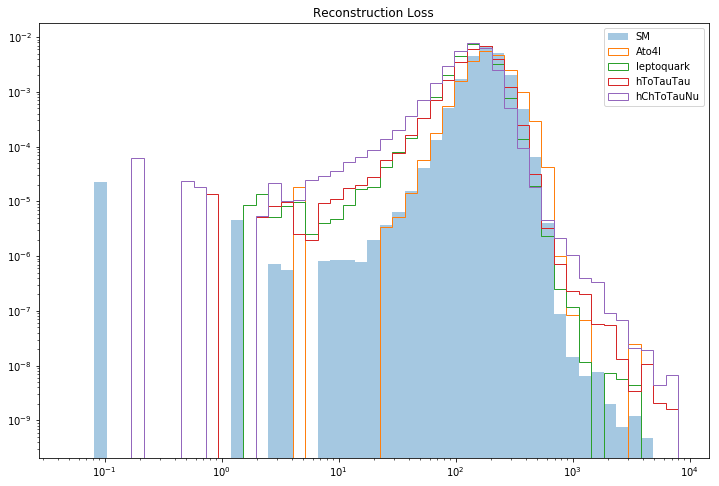

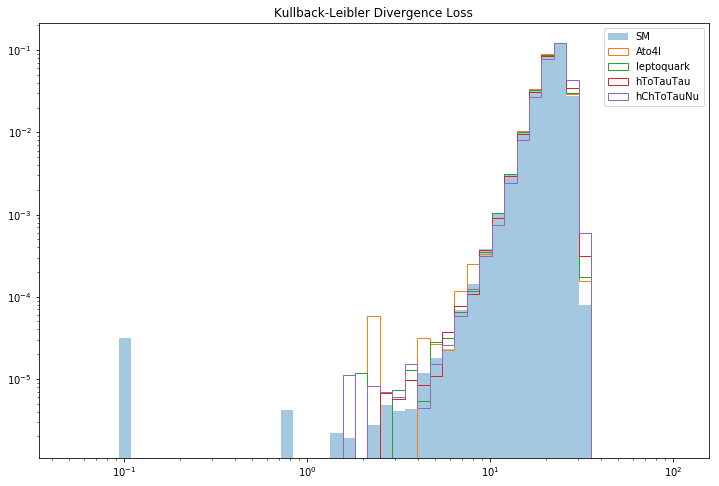

In [48]:
plt.figure(figsize=(12,8))

eps = 1e-1

plt.hist(val_re_loss-min_reco+eps, bins=np.logspace(np.log10(eps/2),np.log10(max_reco*2), 50),label='SM', range=(0,1500), alpha=0.4, normed=True)
for i,n in enumerate(dataset.BSM_names):
    plt.hist(BSM_RE_Loss[n]-min_reco+eps,bins=np.logspace(np.log10(eps/2),np.log10(max_reco*2), 50),label=n, range=(0,1500), histtype='step', normed=True)
plt.legend(loc='best')
plt.yscale('log')
plt.xscale('log')
plt.title("Reconstruction Loss")
plt.show()

plt.figure(figsize=(12,8))
plt.hist(val_kl_loss-min_kl+eps, bins=np.logspace(np.log10(eps/2),np.log10(max_kl*2), 50),label='SM', range=(0,1500), alpha=0.4, normed=True)
for i,n in enumerate(dataset.BSM_names):
    plt.hist(BSM_KL_Loss[n]-min_kl+eps,bins=np.logspace(np.log10(eps/2),np.log10(max_kl*2), 50),label=n, range=(0,1500), histtype='step', normed=True)
plt.legend(loc='best')
plt.yscale('log')
plt.xscale('log')
plt.title("Kullback-Leibler Divergence Loss")
plt.show()

# plt.subplot(3,2,2)
# for i,name in enumerate(SM_Labels):
#     plt.hist(all_kl_loss[all_label==i],bins=np.logspace(np.log10(min_kl),np.log10(np.max(bsm_kl_loss)), 50),label=name, range=(0.03,np.max(bsm_kl_loss)),histtype='step', normed=True)
# plt.title("KL loss")
# plt.legend(loc='best')
# plt.yscale('log')
# plt.xscale('log')

# plt.subplot(3,2,4)    
# for i,name in enumerate(BSM):
#     plt.hist(bsm_kl_loss[bsm_label==i],bins=np.logspace(np.log10(min_kl),np.log10(np.max(bsm_kl_loss)), 50),label=name,range=(0.03,np.max(bsm_kl_loss)), histtype='step', normed=True)
# plt.legend(loc='best')
# plt.yscale('log')
# plt.xscale('log')

# plt.subplot(3,2,5)
# plt.hist(all_re_loss,bins=np.logspace(np.log10(min_reco),np.log10(np.max(bsm_re_loss)), 50),label='SM', range=(min_reco, np.max(bsm_re_loss)), histtype='step', normed=True)
# plt.hist(bsm_re_loss,bins=np.logspace(np.log10(min_reco),np.log10(np.max(bsm_re_loss)), 50),label='BSM',range=(min_reco, np.max(bsm_re_loss)), histtype='step', normed=True)
# plt.legend(loc='best')
# plt.yscale('log')
# plt.xscale('log')

# plt.subplot(3,2,6)
# plt.hist(all_kl_loss,bins=np.logspace(np.log10(min_kl),np.log10(np.max(bsm_kl_loss)), 50),label='SM', range=(min_kl, np.max(bsm_kl_loss)), histtype='step', normed=True)
# plt.hist(bsm_kl_loss,bins=np.logspace(np.log10(min_kl),np.log10(np.max(bsm_kl_loss)), 50),label='BSM',range=(min_kl,np.max(bsm_kl_loss)), histtype='step', normed=True)
# plt.legend(loc='best')
# plt.yscale('log')
# plt.xscale('log')
# plt.show()

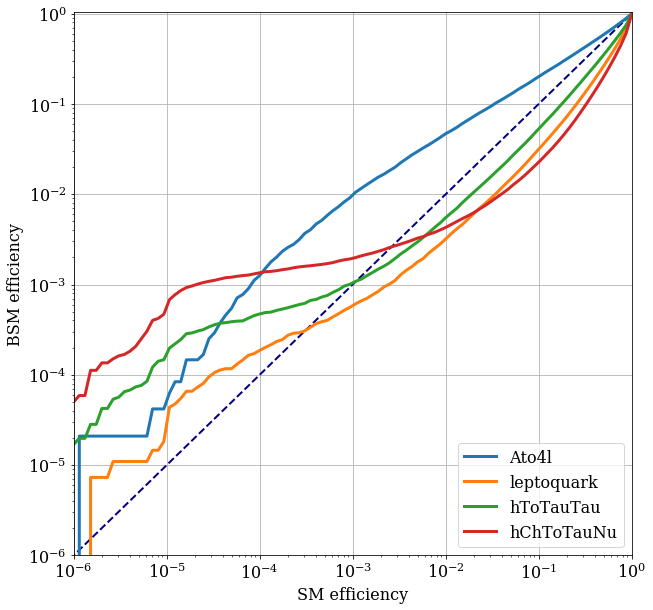

In [49]:
import matplotlib 

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 25,
         }

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = 12, 9
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

p_SM = np.logspace(base=10, start=-6, stop=0, num=100)
p_SM[-1] = 0.999

f_ROC, ax_arr_ROC = plt.subplots(1,1, figsize=(10,10))
ax_arr_ROC.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

ax_arr_ROC.set_xlim([1e-6, 1.0])
ax_arr_ROC.set_ylim([1e-6, 1.05])
ax_arr_ROC.set_xlabel('SM efficiency', fontdict={'size': 16})
ax_arr_ROC.ticklabel_format()
ax_arr_ROC.set_ylabel('BSM efficiency', fontdict={'size': 16})
ax_arr_ROC.set_yscale('log')
ax_arr_ROC.set_xscale('log')
ax_arr_ROC.grid()

# First sort the SM distribution
sm_sort = np.argsort(val_re_loss)
sm_re_loss = val_re_loss[sm_sort]

# Find out the sm threshold values corresponding to each percentile in p_SM
frac = np.cumsum(np.ones_like(sm_re_loss)/len(sm_re_loss)) # an array of fraction (1/n, 2/n, etc.)
indices_of_thresholds = np.argmax(frac > np.atleast_2d(1-p_SM).T, axis=1) # which element closest to each value in p_SM
sm_thresholds = sm_re_loss[indices_of_thresholds] # what are the corresponding threshold values

for i,name in enumerate(dataset.BSM_names):
    bsm = dataset.loss[name]
    # For each of the threshold above, compute the fraction of BSM events that would be selected at that SM threshold
    bsm_frac = np.float64(np.sum(bsm > np.atleast_2d(sm_thresholds).T, axis=1, dtype=np.float128)/len(bsm))
    # Voila
    ax_arr_ROC.plot(p_SM,bsm_frac,label=name)

ax_arr_ROC.legend(loc="lower right", fontsize=16)

# Total Loss

In [50]:
import collections
all_total_loss = val_re_loss + val_kl_loss
BSM_Total_Loss = collections.defaultdict()
for i,name in enumerate(dataset.BSM_names):
    BSM_Total_Loss[name] = BSM_KL_Loss[name] + BSM_RE_Loss[name]

plt.figure(figsize=(12,8))
min_tot = min(np.min(all_total_loss),np.min(all_total_loss))
# plt.hist(all_total_loss, bins=np.logspace(np.log10(min_tot),np.log10(np.max(all_total_loss)*2), 50),label='SM', range=(0,1500), alpha=0.4, normed=True)
# for i,n in enumerate(dataset.BSM_names):
#     plt.hist(BSM_Total_Loss[n],bins=np.logspace(np.log10(min_tot),np.log10(np.max(all_total_loss)*2), 50),label=n, range=(0,1500), histtype='step', normed=True)
# plt.legend(loc='best')
# plt.yscale('log')
# plt.xscale('log')
# plt.title("Total Loss")
# plt.show()

<Figure size 864x576 with 0 Axes>

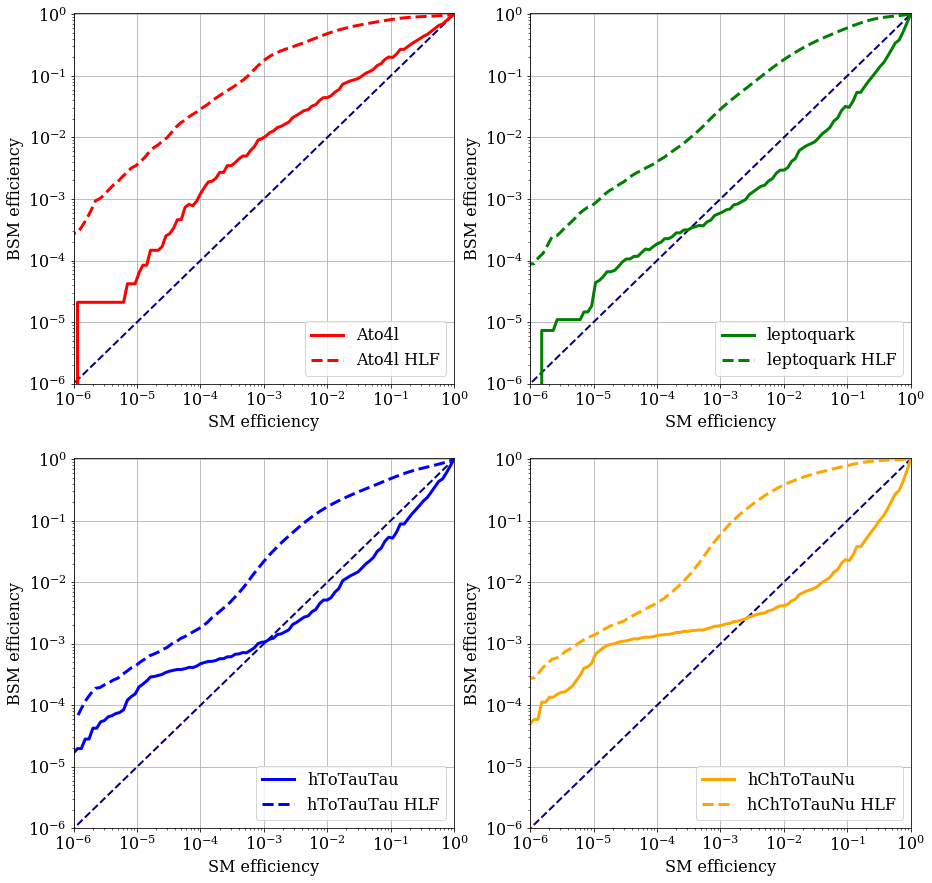

In [51]:
import pickle

p_SM = np.logspace(base=10, start=-6, stop=0, num=100)
p_SM[-1] = 0.999

f_ROC, ax_arr_ROC = plt.subplots(2,2, figsize=(15,15))
# First sort the SM distribution
# sm_sort = np.argsort(all_total_loss)
sm_total_loss = all_total_loss[sm_sort]

# Find out the sm threshold values corresponding to each percentile in p_SM
frac = np.cumsum(np.ones_like(sm_total_loss)/len(sm_total_loss)) # an array of fraction (1/n, 2/n, etc.)
indices_of_thresholds = np.argmax(frac > np.atleast_2d(1-p_SM).T, axis=1) # which element closest to each value in p_SM
sm_thresholds = sm_total_loss[indices_of_thresholds] # what are the corresponding threshold values

colors = ['r','g','b','orange']
dRef = collections.defaultdict()
fRef = collections.defaultdict()
for i,name in enumerate(dataset.BSM_names):
    ax = ax_arr_ROC[int(i/2), i%2]
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([1e-6, 1.0])
    ax.set_ylim([1e-6, 1.05])
    ax.set_xlabel('SM efficiency', fontdict={'size': 16})
    ax.ticklabel_format()
    ax.set_ylabel('BSM efficiency', fontdict={'size': 16})
    ax.set_yscale('log')
    ax.set_xscale('log')
    #ax.set_title('Total Loss')
    ax.grid()

    bsm = BSM_Total_Loss[name]
    # For each of the threshold above, compute the fraction of BSM events that would be selected at that SM threshold
    bsm_frac = np.float64(np.sum(bsm > np.atleast_2d(sm_thresholds).T, axis=1, dtype=np.float128)/len(bsm))
    # Voila
    ax.plot(p_SM,bsm_frac,label=name, color=colors[i])
    with open('/nfshome/thong/AnomalyDetection/HLFRef/VAE_all-in-one_v71_ROC1_dict_{}.pkl'.format(name), 'br') as f:
        dRef[name] = pickle.load(f, encoding='bytes')
        ax.plot(dRef[name][b'eff_SM'], dRef[name][b'eff_BSM'], linestyle='--', label=name+" HLF", color=colors[i])

    ax.legend(loc="lower right", fontsize=16)

In [32]:
idx_max = 1000
from sklearn.manifold import TSNE

z_dset = np.array([])
for i,name in enumerate(['Wlnu', 'qcd', 'Zll', 'ttbar']):
    z_dset = np.concatenate((z_dset, all_z_mean[name][:idx_max])) if z_dset.size else all_z_mean[name][:idx_max]
for i,name in enumerate(dataset.BSM_names):
    z_dset = np.concatenate((z_dset, BSM_z_mean[name][:idx_max]))
z_embedded = TSNE(n_components=2).fit_transform(z_dset)


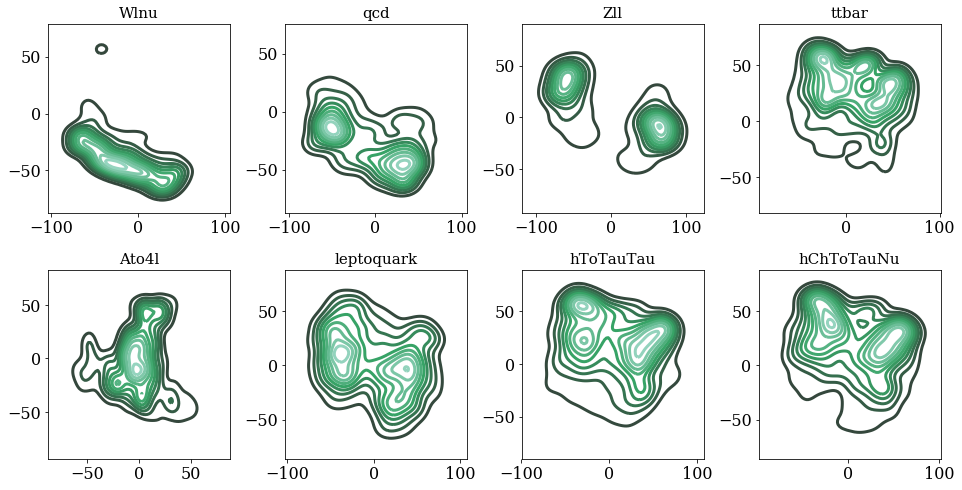

In [33]:
import seaborn as sns
all_labels = ['Wlnu', 'qcd', 'Zll', 'ttbar', 'Ato4l', 'leptoquark', 'hToTauTau', 'hChToTauNu']
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i, n in enumerate(all_labels):
    aux_z = z_embedded[i*idx_max: (i+1)*idx_max]
    ax = plt.subplot(2,4,i+1)
    sns.kdeplot(aux_z[:,0], aux_z[:,1], ax=ax)
    #ax.set_xlabel('Embedded 0')
    #ax.set_ylabel('Embedded 1')
    ax.set_title(n, fontsize=15)
plt.show()
        


In [ ]:

plt.hist(all_re_loss,bins=np.logspace(np.log10(10),np.log10(np.max(bsm_re_loss)), 50),label='SM', range=(0,1500), histtype='stepfilled', alpha=0.2,normed=True)
for i,name in enumerate(BSM):
    plt.hist(bsm_re_loss[bsm_label==i],bins=np.logspace(np.log10(10),np.log10(np.max(bsm_re_loss)), 50),label=name, range=(0,1500), histtype='step', normed=True)
plt.legend(loc='best')
plt.yscale('log')
plt.xscale('log')

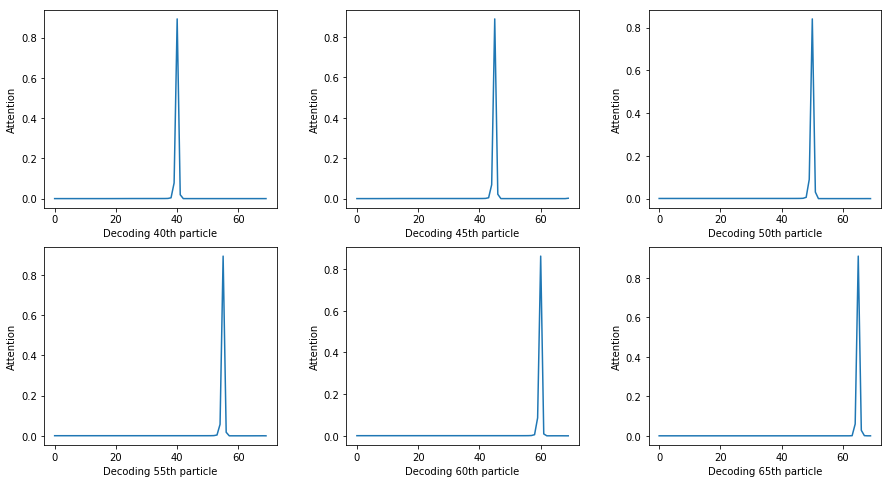

In [71]:
plt.figure(figsize=(15,8))
order = 1
plt.subplots_adjust(wspace=0.3)
for i in range(40,70,5):
    plt.subplot(2,3,order)
    x = attns[i,:,0]
    plt.plot(x.cpu().data.numpy())
    plt.xlabel("Decoding {}th particle".format(i))
    plt.ylabel("Attention")
    order += 1
plt.show()

In [26]:
from matplotlib.colors import LogNorm

attentions = attns[:,:,0].cpu().data.numpy()
plt.figure(figsize=(12,10))
plt.imshow(attentions, norm=LogNorm(3e-3,1), aspect = 'auto')
plt.colorbar()
plt.xlabel('Input sequence',fontsize=15)
plt.ylabel('Decoded particle',fontsize=15)
plt.show()

NameError: name 'attns' is not defined

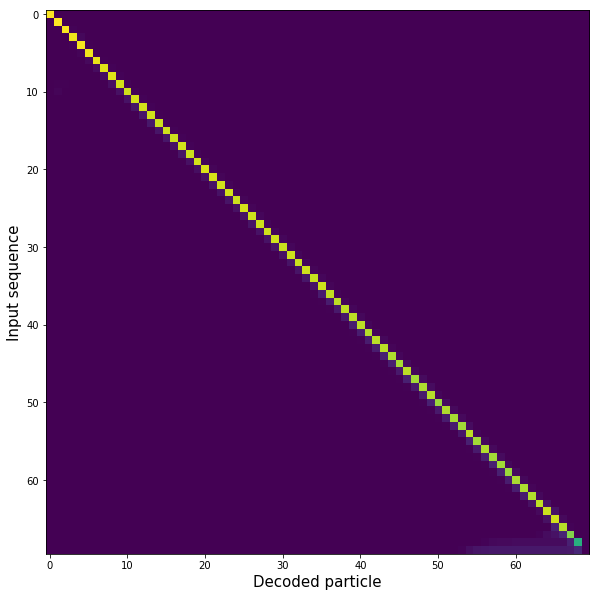

In [73]:
bsmattentions = bsm_attns[:,:,0].cpu().data.numpy()
plt.figure(figsize=(10,10))
plt.imshow(bsmattentions)
plt.xlabel('Decoded particle',fontsize=15)
plt.ylabel('Input sequence',fontsize=15)
plt.show()

In [39]:
# x_sig_encoded = {}
# logvar_x_sig_encoded = {}

# for i,bsm in enumerate(BSM):
#     selected = all_label_bsm==i
#     x_sig_encoded[bsm] = np.zeros(shape=(all_z_mean_bsm[selected].shape[0],LATENT_DIM))
#     logvar_x_sig_encoded[bsm] = np.zeros(shape=(all_z_mean_bsm[selected].shape[0],LATENT_DIM))
    
#     for batch_idx, (data,label) in enumerate(bsm_loader):
#         inputs, targets = data['Particles'].numpy()[:,:801,:], data['Labels'].numpy()
#         data = data.numpy()[:,:801,:]
#         x_val_cuda, weight_val_cuda, sorted_idx = pack_data(data, weight=None, volatile=True)
#         x_val_encoded, logvar_x_val_encoded = model.encode(x_val_cuda)
#         if batch_idx%100: 
#             print("{}: {}/{}".format(bsm, batch_idx*len(data), len(bsm_loader)*len(data)*BATCH_SIZE))
#         label = label.numpy()[sorted_idx]
#         fill_array(x_sig_encoded[bsm], x_val_encoded.cpu().data.numpy(), batch_idx, BATCH_SIZE)
#         fill_array(logvar_x_sig_encoded[bsm], logvar_x_val_encoded.cpu().data.numpy(), batch_idx, BATCH_SIZE)




KL_SM = torch.sum(-(1+torch.from_numpy(all_z_logvar)-torch.from_numpy(all_z_mean).pow(2)-torch.from_numpy(all_z_logvar).exp()),dim=1).numpy()
KL_BSM = {}
for i, bsm in enumerate(BSM):
    selected = real_label_bsm==i
    KL_BSM[bsm] = torch.sum(-(1+torch.from_numpy(real_z_logvar_bsm[selected])-torch.from_numpy(real_z_mean_bsm[selected]).pow(2)-torch.from_numpy(real_z_logvar_bsm[selected]).exp()),dim=1).numpy()



In [50]:
for i, bsm in enumerate(BSM2):
    selected = real_label_bsm2==i
    KL_BSM[bsm] = torch.sum(-(1+torch.from_numpy(real_z_logvar_bsm2[selected])-torch.from_numpy(real_z_mean_bsm2[selected]).pow(2)-torch.from_numpy(real_z_logvar_bsm2[selected]).exp()),dim=1).numpy()



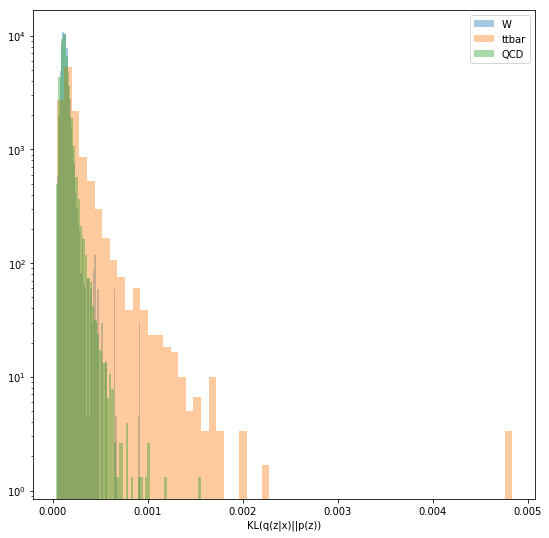

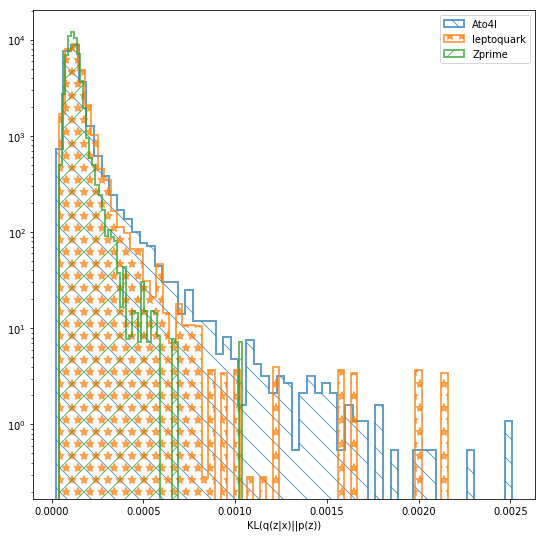

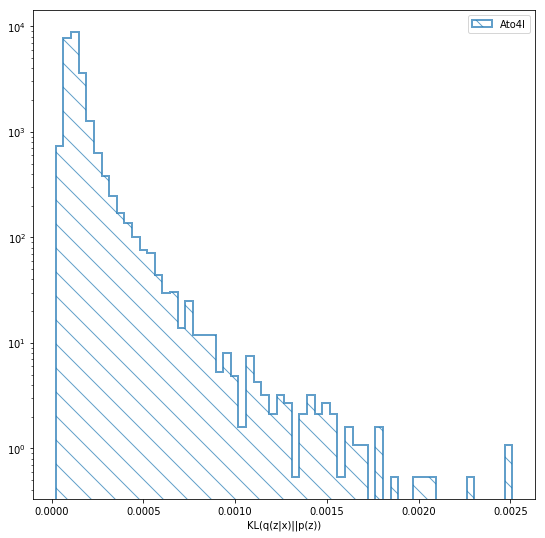

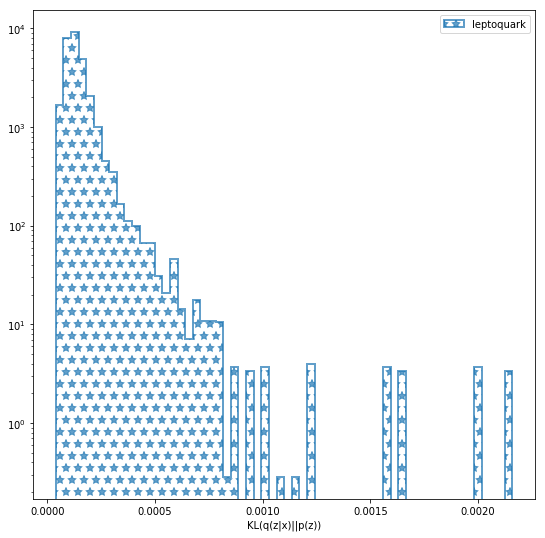

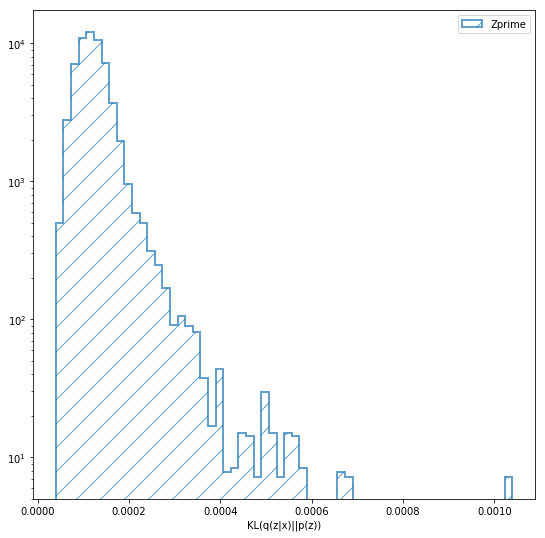

In [40]:
samples_name=['QCD','ttbar','W']
hatches = ['\\','*','/','-','.']
plt.figure(figsize=(9,9))
for i in reversed(range(3)):
    cut = all_label == i
    plt.hist(KL_SM[cut],
                 bins=60,
                 histtype='bar',
                 alpha=0.4,
                 linewidth=2.0,
                 normed=True,
                 label=samples_name[i])
    
# for i,bsm in enumerate(BSM):
#     plt.hist(KL_BSM[bsm], bins=60, histtype='step', alpha=0.7,
#              linewidth=2.0,
#              normed=True,
#              label=bsm, hatch=hatches[i] #, weights=4e6/BSM_size[i]*np.ones(BSM_size[i])
#             )
plt.xlabel('KL(q(z|x)||p(z))')
#plt.xlim(0, 0.00003)
plt.yscale('log')
#plt.legend(bbox_to_anchor=(0., 1.05, 1., .12), ncol=2)
plt.legend(loc='best')
plt.show()
plt.figure(figsize=(9,9))
for i,bsm in enumerate(BSM):
    plt.hist(KL_BSM[bsm], bins=60, histtype='step', alpha=0.7,
             linewidth=2.0,
             normed=True,
             label=bsm, hatch=hatches[i] #, weights=4e6/BSM_size[i]*np.ones(BSM_size[i])
            )
plt.xlabel('KL(q(z|x)||p(z))')
#plt.xlim(0, 0.00003)
plt.yscale('log')
#plt.legend(bbox_to_anchor=(0., 1.05, 1., .12), ncol=2)
plt.legend(loc='best')
plt.show()

for i,bsm in enumerate(BSM):
    plt.figure(figsize=(9,9))
    plt.hist(KL_BSM[bsm], bins=60, histtype='step', alpha=0.7,
             linewidth=2.0,
             normed=True,
             label=bsm, hatch=hatches[i] #, weights=4e6/BSM_size[i]*np.ones(BSM_size[i])
            )
    plt.xlabel('KL(q(z|x)||p(z))')
    #plt.xlim(0, 0.00003)
    plt.yscale('log')
    #plt.legend(bbox_to_anchor=(0., 1.05, 1., .12), ncol=2)
    plt.legend(loc='best')
    plt.show()

In [41]:
weight_sm = [100,1,170]
# return the p-value of x0, given a distribution of x values
def pValue(x0, x):
    isGreater = x>x0
    return isGreater.sum()/float(len(x))

KL_qcd = np.repeat(KL_SM[all_label==0], weight_sm[0])
KL_tt = np.repeat(KL_SM[all_label==1], weight_sm[1])
KL_w = np.repeat(KL_SM[all_label==2], weight_sm[2])
weighted_KL_SM = np.concatenate([KL_qcd, KL_tt, KL_w])
print(weighted_KL_SM.shape)

# for each SM event, compute the corresponding quantile in the SM distribution
pValue_klsm = [pValue(x0, weighted_KL_SM) for x0 in np.random.choice(weighted_KL_SM,100000)]
print ("Done for SM")
# for each BSM event, compute the corresponding quantile in the SM distribution
from itertools import repeat
pValue_klbsm = {}
for i,bsm in enumerate(BSM):
    kl_bsm = np.squeeze(KL_BSM[bsm])
    pValue_klbsm[bsm] = [pValue(x0, weighted_KL_SM) for x0 in np.random.choice(kl_bsm,min(100000, len(kl_bsm)))]
    print("Done for {}".format(bsm))
    
# Compute the p-value of ttbar event
pValue_tt = [pValue(x0, weighted_KL_SM) for x0 in np.random.choice(KL_SM[all_label==1], 100000)]
print("Done for ttbar")
# Compute the p-value of QCD event
pValue_qcd = [pValue(x0, weighted_KL_SM) for x0 in np.random.choice(KL_SM[all_label==0], 100000)]
print("Done for QCD")
# Compute the p-value of W event
pValue_w = [pValue(x0, weighted_KL_SM) for x0 in np.random.choice(KL_SM[all_label==2], 100000)]
print("Done for W")

(8130000,)
Done for SM
Done for Ato4l
Done for leptoquark
Done for Zprime
Done for ttbar
Done for QCD
Done for W


In [53]:
from multiprocessing import Pool
import time

def pValue(x0):
    global weighted_KL_SM
    isGreater = weighted_KL_SM>x0
    return isGreater.sum()/float(len(weighted_KL_SM))

pool = Pool(processes=24)
begt = time.time()
for i,bsm in enumerate(BSM2):
    begt = time.time()
    kl_bsm = np.squeeze(KL_BSM[bsm])
    pValue_klbsm[bsm] = pool.map(pValue,kl_bsm)
    print("Done for {} in {}s".format(bsm, time.time()-begt))

    
    

Done for HiggsToTauTau in 154.10607767105103s
Done for ChHiggsToTauNu in 155.6258671283722s
Done for Wprime in 161.56739449501038s


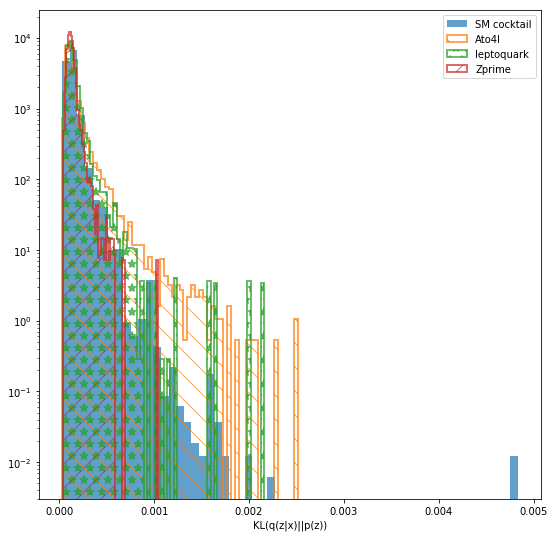

In [42]:
plt.figure(figsize=(9,9))
plt.hist(weighted_KL_SM,
         bins=60, histtype='stepfilled', alpha=0.7,
             linewidth=2.0,
             normed=True,
             label='SM cocktail')
         
for i,bsm in enumerate(BSM):   
    plt.hist(KL_BSM[bsm], bins=60, histtype='step', alpha=0.7,
             linewidth=2.0,
             normed=True,
             label=bsm, hatch=hatches[i] #, weights=4e6/BSM_size[i]*np.ones(BSM_size[i])
            )
plt.xlabel('KL(q(z|x)||p(z))')
#plt.xlim(0, 0.00003)
plt.yscale('log')
#plt.legend(bbox_to_anchor=(0., 1.05, 1., .12), ncol=2)
plt.legend(loc='best')
plt.show()

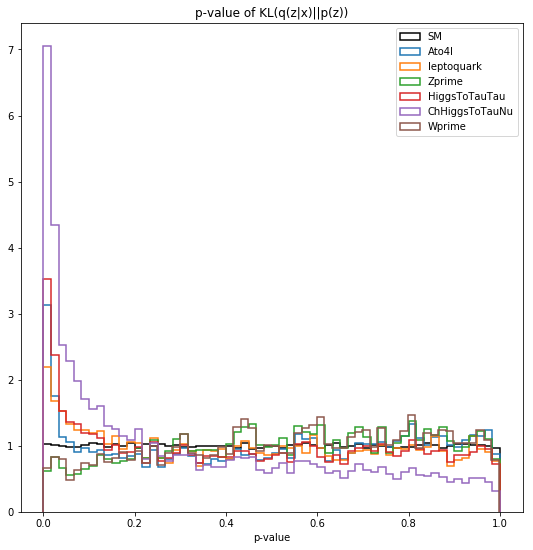

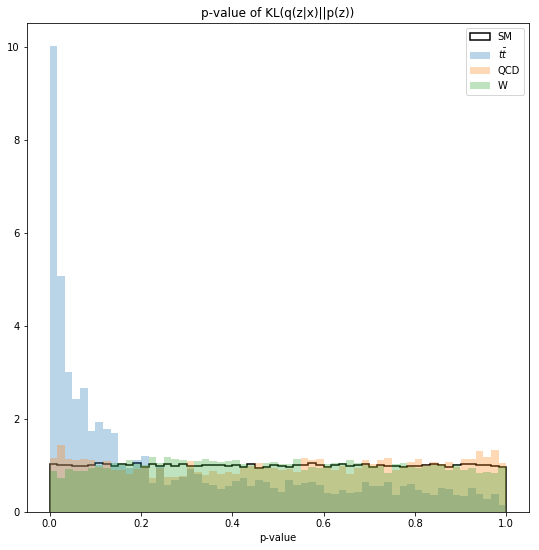

Fractions of events 
Physics\p-value   | 5.00E-2 | 1.00E-2 | 1.00E-3 | 1.00E-4 | 1.00E-5 | 
ttbar             |3.02E-1 | 1.22E-1 | 2.96E-2 | 1.10E-2 | 2.30E-3 | 
QCD               |6.23E-2 | 1.04E-2 | 5.40E-4 | 1.40E-4 | 1.00E-5 | 
Wjets             |4.20E-2 | 9.51E-3 | 9.30E-4 | 0.00E+2 | 0.00E+2 | 
Ato4l             |0.10033 | 0.03600 | 0.00729 | 0.00218 | 0.00033 | 
leptoquark        |0.08996 | 0.02089 | 0.00288 | 0.00091 | 0.00058 | 
Zprime            |0.03525 | 0.00539 | 0.00042 | 0.00017 | 0.00000 | 
HiggsToTauTau     |0.12384 | 0.03998 | 0.00966 | 0.00398 | 0.00110 | 
ChHiggsToTauNu    |0.23198 | 0.07906 | 0.01812 | 0.00636 | 0.00144 | 
Wprime            |0.03810 | 0.00548 | 0.00048 | 0.00024 | 0.00000 | 

In [58]:
# plot the p-values
plt.figure(figsize=(9,9))
plt.hist(pValue_klsm, bins=60, histtype = 'step', color='black', linewidth=1.5, label='SM', normed=True)
#plt.hist(pValue_tt, bins=60, histtype='stepfilled', linewidth=1.5, alpha=0.3, label=r'$t \bar{t}$', normed=True)
ALL_BSM = BSM+BSM2
for i, bsm in enumerate(ALL_BSM):
    plt.hist(pValue_klbsm[bsm], bins=60, histtype='step', linewidth=1.5, label=bsm, normed=True)

plt.title('p-value of KL(q(z|x)||p(z))')
plt.xlabel('p-value')
plt.legend(loc='best')
#plt.yscale('log')
plt.show()

# plot the p-values
plt.figure(figsize=(9,9))
plt.hist(pValue_klsm, bins=60, histtype = 'step', color='black', linewidth=1.5, label='SM', normed=True)
plt.hist(pValue_tt, bins=60, histtype='stepfilled', linewidth=1.5, alpha=0.3, label=r'$t \bar{t}$', normed=True)
plt.hist(pValue_qcd, bins=60, histtype='stepfilled', linewidth=1.5, alpha=0.3, label='QCD', normed=True)
plt.hist(pValue_w, bins=60, histtype='stepfilled', linewidth=1.5, alpha=0.3, label='W', normed=True)

plt.title('p-value of KL(q(z|x)||p(z))')
plt.xlabel('p-value')
plt.legend(loc='best')
#plt.yscale('log')
plt.show()


from decimal import Decimal
print("Fractions of events ")
thresholds = [0.05, 1e-2, 1e-3, 1e-4, 1e-5]
print("Physics\p-value   | ", end='')
for pval in thresholds: print("{0:.2E} | ".format(Decimal(pval)), end='')
## ttbar
fracs = [float((np.array(pValue_tt)<pval).sum())/float(len(pValue_tt)) for pval in thresholds]
print("\n{:<17} |".format("ttbar"), end = '')
for frac in fracs: print("{0:.2E} | ".format(Decimal(frac)),end='')
## qcd
fracs = [float((np.array(pValue_qcd)<pval).sum())/float(len(pValue_qcd)) for pval in thresholds]
print("\n{:<17} |".format("QCD"), end = '')
for frac in fracs: print("{0:.2E} | ".format(Decimal(frac)),end='')
## wjets
fracs = [float((np.array(pValue_w)<pval).sum())/float(len(pValue_w)) for pval in thresholds]
print("\n{:<17} |".format("Wjets"), end = '')
for frac in fracs: print("{0:.2E} | ".format(Decimal(frac)),end='')
# bsm
for i, bsm in enumerate(ALL_BSM):
    fracs = [float((np.array(pValue_klbsm[bsm])<pval).sum())/float(len(pValue_klbsm[bsm])) for pval in thresholds]
    print("\n{:<17} |".format(bsm),end='')
    for frac in fracs: print("{0:.5f} | ".format(frac),end='')



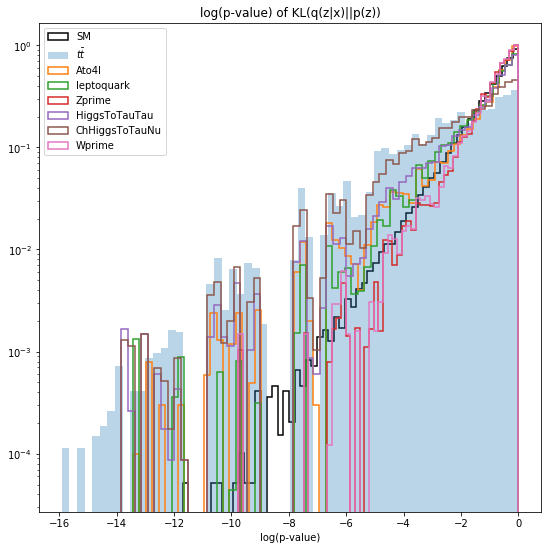

In [56]:
pValue_klsm = np.asarray(pValue_klsm)
pValue_tt = np.asarray(pValue_tt)
plt.figure(figsize=(9,9))
plt.hist(np.log(pValue_klsm[pValue_klsm>0]), bins=60, histtype = 'step', color='black', linewidth=1.5, label='SM', normed=True)
plt.hist(np.log(pValue_tt[pValue_tt>0]), bins=60, histtype='stepfilled', linewidth=1.5, alpha=0.3, label=r'$t \bar{t}$', normed=True)
for i, bsm in enumerate(ALL_BSM):
    pValue_klbsm[bsm] = np.asarray(pValue_klbsm[bsm])
    plt.hist(np.log(pValue_klbsm[bsm][pValue_klbsm[bsm]>0]), bins=60, histtype='step', linewidth=1.5, label=bsm, normed=True)

plt.title('log(p-value) of KL(q(z|x)||p(z))')
plt.xlabel('log(p-value)')
plt.legend(loc='best')
plt.yscale('log')
plt.show()


In [60]:
from prettytable import PrettyTable
acquisition_sec_per_year = 1e7
lumi_per_yr = 50 #fb-1
trigger_rate = {'Wlnu':440. ,'qcd':251., 'ttbar':2.5} #Hz
cutoff = 1e-5
print("SM p-value cutoff: {:.1E}".format(Decimal(cutoff)))
table = PrettyTable(['Sample', 'Efficiency','Rate [Hz]', 'evts/month'])

frac_tt = float((np.array(pValue_tt)<cutoff).sum())/float(len(pValue_tt)) 
d_frac_tt = np.sqrt(frac_tt*(1-frac_tt)/float(len(pValue_tt)))
table.add_row(['ttbar',"{:.1E} +/- {:.1E}".format(Decimal(frac_tt), Decimal(d_frac_tt)),
               "{:.1E}".format(Decimal(frac_tt*trigger_rate['ttbar'])),
               "{:.1E} +/- {:.1E}".format(Decimal(acquisition_sec_per_year/12.*frac_tt*trigger_rate['ttbar']),
                                       Decimal(acquisition_sec_per_year/12.*d_frac_tt*trigger_rate['ttbar']))])
frac_qcd = float((np.array(pValue_qcd)<cutoff).sum())/float(len(pValue_qcd)) 
d_frac_qcd = np.sqrt(frac_qcd*(1-frac_qcd)/float(len(pValue_qcd)))
table.add_row(['QCD',"{:.1E} +/- {:.1E}".format(Decimal(frac_qcd), Decimal(d_frac_qcd)),
               "{:.1E}".format(Decimal(frac_qcd*trigger_rate['qcd'])),
               "{:.1E} +/- {:.1E}".format(Decimal(acquisition_sec_per_year/12.*frac_qcd*trigger_rate['qcd']),
                                       Decimal(acquisition_sec_per_year/12.*d_frac_qcd*trigger_rate['qcd']))])
frac_wjets = float((np.array(pValue_w)<cutoff).sum())/float(len(pValue_w)) 
d_frac_wjets = np.sqrt(frac_wjets*(1-frac_wjets)/float(len(pValue_w)))
table.add_row(['Wlnu',"{:.1E} +/- {:.1E}".format(Decimal(frac_wjets), Decimal(d_frac_wjets)),
               "{:.1E}".format(Decimal(frac_wjets*trigger_rate['Wlnu'])),
               "{:.1E} +/- {:.1E}".format(Decimal(acquisition_sec_per_year/12.*frac_wjets*trigger_rate['Wlnu']),
                                       Decimal(acquisition_sec_per_year/12.*d_frac_wjets*trigger_rate['Wlnu']))])
print(table)

N_tot = (frac_tt*trigger_rate['ttbar']+frac_qcd*trigger_rate['qcd']+frac_wjets*trigger_rate['Wlnu']) * acquisition_sec_per_year/12.
d_N_tot = np.sqrt((np.square(frac_tt*trigger_rate['ttbar'])+np.square(frac_qcd*trigger_rate['qcd'])+np.square(frac_wjets*trigger_rate['Wlnu']))*np.square(acquisition_sec_per_year/12.))
print("Expected evts/month: {:.0f} +/- {:.0f}".format(N_tot, d_N_tot))

table = PrettyTable(['Sample', 'Efficiency', 'xsec (10 evts/month) [fb]', 'xsec (S/B = 0.3) [fb]'])

for i, bsm in enumerate(ALL_BSM):
    frac = float((np.array(pValue_klbsm[bsm])<cutoff).sum())/float(len(pValue_klbsm[bsm]))
    d_frac = np.sqrt(frac*(1-frac)/float(len(pValue_klbsm[bsm])))
    #if frac == 0: frac = 1e-99
    x_sec_lim = 10. * 12/ (lumi_per_yr * frac) if frac!=0 else np.nan
    x_sec_SoB = 0.3*N_tot*12/ (lumi_per_yr * frac) if frac!=0 else np.nan
    table.add_row([bsm, '{:.1e} +/- {:.1e}'.format(Decimal(frac), Decimal(d_frac)), 
                   '{:.1E}'.format(Decimal(x_sec_lim)),
                   '{:.1E}'.format(Decimal(x_sec_SoB))])
        
print(table)

SM p-value cutoff: 1.0E-5
+--------+-------------------+-----------+-------------------+
| Sample |     Efficiency    | Rate [Hz] |     evts/month    |
+--------+-------------------+-----------+-------------------+
| ttbar  | 2.3E-3 +/- 1.5E-4 |   5.7E-3  | 4.8E+3 +/- 3.2E+2 |
|  QCD   | 1.0E-5 +/- 1.0E-5 |   2.5E-3  | 2.1E+3 +/- 2.1E+3 |
|  Wlnu  | 0.0E+1 +/- 0.0E+1 |   0.0E+1  | 0.0E+1 +/- 0.0E+1 |
+--------+-------------------+-----------+-------------------+
Expected evts/month: 6883 +/- 5228
+----------------+-------------------+---------------------------+-----------------------+
|     Sample     |     Efficiency    | xsec (10 evts/month) [fb] | xsec (S/B = 0.3) [fb] |
+----------------+-------------------+---------------------------+-----------------------+
|     Ato4l      | 3.3e-4 +/- 8.6e-5 |           7.2E+3          |         1.5E+6        |
|   leptoquark   | 5.8e-4 +/- 7.6e-5 |           4.1E+3          |         8.5E+5        |
|     Zprime     | 0.0e+1 +/- 0.0e+1 |     

In [ ]:
import matplotlib 

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 25,
         }

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = 12, 9
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

p_SM = np.logspace(base=10, start=-5, stop=0, num=100)
p_SM[-1] = 0.999

f_ROC, ax_arr_ROC = plt.subplots(1,1, figsize=(10,10))
ax_arr_ROC.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

ax_arr_ROC.set_xlim([1e-4, 1.0])
ax_arr_ROC.set_ylim([1e-4, 1.05])
ax_arr_ROC.set_xlabel('SM efficiency', fontdict={'size': 16})
ax_arr_ROC.ticklabel_format()
ax_arr_ROC.set_ylabel('BSM efficiency', fontdict={'size': 16})
ax_arr_ROC.set_yscale('log')
ax_arr_ROC.set_xscale('log')
ax_arr_ROC.grid()

# First sort the SM distribution
sm_sort = np.argsort(loss_sm)
sm_re_loss = loss_sm[sm_sort]

# Find out the sm threshold values corresponding to each percentile in p_SM
frac = np.cumsum(np.ones_like(sm_re_loss)/len(sm_re_loss)) # an array of fraction (1/n, 2/n, etc.)
indices_of_thresholds = np.argmax(frac > np.atleast_2d(1-p_SM).T, axis=1) # which element closest to each value in p_SM
sm_thresholds = sm_re_loss[indices_of_thresholds] # what are the corresponding threshold values

for i,name in enumerate(BSM):
    bsm = loss_bsm[label_bsm_index==i]
    # For each of the threshold above, compute the fraction of BSM events that would be selected at that SM threshold
    bsm_frac = np.float64(np.sum(bsm > np.atleast_2d(sm_thresholds).T, axis=1, dtype=np.float128)/len(bsm))
    # Voila
    ax_arr_ROC.plot(p_SM,bsm_frac,label=name)

ax_arr_ROC.legend(loc="lower right", fontsize=16)